In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
#
import tensorflow as tf
#import keras.backend.tensorflow_backend as KTF
gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    tensorflow.config.experimental.set_memory_growth(device,True)
    
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [3]:
%load_ext autoreload
%autoreload 2
#%tensorflow_version 1.x
import tensorflow 
import numpy as np
 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Reshape,Activation,Attention,MaxPool1D,Dense, Conv1D, Convolution2D, GRU, LSTM, Lambda, Bidirectional, TimeDistributed,
                          Dropout, Flatten, LayerNormalization,RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
import tensorflow.keras.layers as layers
import string
from tensorflow.keras.regularizers import l1, l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as keras
import datetime

import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import sys
#sys.path.append('/content/pyNSID/')
#import pyNSID as nsid
import matplotlib.pyplot as plt
#import sidpy as sid
#import h5py
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from os.path import join as pjoin
from scipy import ndimage

In [4]:
from tensorflow.keras.callbacks import History 

In [5]:
import tensorflow

In [6]:
tensorflow.__version__

'2.1.0'

In [8]:
image.shape

(142, 117, 3)

In [8]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [9]:
pie_data = np.load('pizoresponse.npy')

In [10]:
res_data = np.load('resonance.npy')

In [11]:
vol = np.load('voltage.npy')

In [12]:
vol.shape

(96, 1)

In [13]:
res_data.shape

(3600, 96)

In [14]:
np.max(res_data)

3.6364999096008983

In [15]:
res_data = np.atleast_3d(res_data)

In [16]:
new_data = np.concatenate((pie_data,res_data),axis=2)

In [17]:
new_data.shape

(3600, 96, 2)

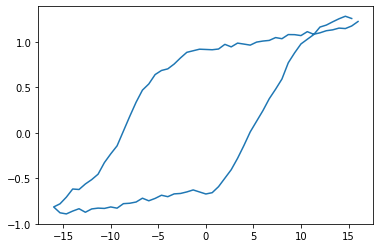

In [18]:
plt.plot(vol,new_data[0,:,0])

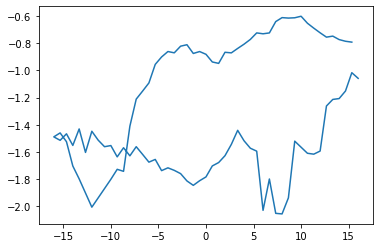

In [19]:
plt.plot(vol,new_data[100,:,1])

# verison of model training piezoresponse and resonance separately

In [23]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class model_builder:
    
    def __init__(self,
                 input_data, 
                drop_frac = 0.2, 
                 layer_size = 128, 
                 num_ident_blocks = 3, 
                 l1_norm = 0,
                 l1_norm_embedding = 1e-3, 
                 layer_steps = 2,
                 embedding = 16, 
                 VAE = True,
                 coef = 1):
    # Sets self.mean and self.std to use in the loss function;
#       self.mean = 0
#       self.std = 0
    
      # Sets the L1 norm on the decoder/encoder layers
      self.l1_norm = l1_norm
 
      # Sets the fraction of dropout
      self.drop_frac = drop_frac
      
      # saves the shape of the input data
      self.data_shape = input_data.shape
 
      # Sets the number of neurons in the encoder/decoder layers
      self.layer_size = layer_size
 
      # Sets the number of neurons in the embedding layer
      self.embedding = embedding 
 
      # Bool to set if the model is a VAE 
      self.VAE = VAE
 
      # Set the magnitude of the l1 regularization on the embedding layer.
      self.l1_norm_embedding = l1_norm_embedding
 
      # sets the number of layers between the residual layer
      self.layer_steps = layer_steps

      self.coef = coef
 
      # set the number of identity block
      self.num_ident_blocks = num_ident_blocks
 
      self.model_constructor(input_data)
 
    def identity_block(self, X, name, 
                      block):
      
      # sets the name of the conv layers
      LSTM_name_base =  name + '_LSTM_Res_' + block
      bn_name_base = name + '_layer_norm_' + block
 
 
      # output for the residual layer
      X_shortcut = X
 
      for i in range(self.layer_steps):
        # bidirectional LSTM
        X = layers.Bidirectional(LSTM(self.layer_size, 
                                      return_sequences=True, 
                                      dropout=self.drop_frac,
                                      activity_regularizer=l1(self.l1_norm)), 
                                input_shape=(self.data_shape[1], self.data_shape[2]))(X)
 
        # TODO, We could add layer norm
        X = layers.Activation('relu')(X)  
 
      X = layers.add([X, X_shortcut])
      X = layers.LayerNormalization(axis = 1, name = bn_name_base + '_res_end')(X)
      X = layers.Activation('relu')(X)
 
      return X
 
    def model_constructor(self, input_data):
      # defines the input
      encoder_input = layers.Input(shape=(self.data_shape[1:]))

      X = encoder_input
      
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'encoder', string.ascii_uppercase[i+1])
        
      # This is in preparation for the embedding layer
      X = layers.Bidirectional(LSTM(self.layer_size, 
                                    return_sequences=False, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)), 
                                    input_shape=(self.data_shape[1], 
                                                 self.data_shape[2]))(X)   
      
      X = layers.BatchNormalization(axis=1, name='last_encode')(X)
      X = layers.Activation('relu')(X)

      if self.VAE:
            
            z_mean = layers.Dense(self.embedding, name="z_mean")(X)
            z_log_var = layers.Dense(self.embedding, name="z_log_var")(X)
            self.to_dense = Sampling()((z_mean, z_log_var))
            z = layers.Dense(self.embedding, name="embedding")(self.to_dense)
            z = layers.Activation('relu')(z)
            z = layers.ActivityRegularization(l1=self.l1_norm_embedding*10**self.coef)(z)
            # update the self.mean and self.std:
#            self.mean = z_mean
#            self.std = z_log_var

      self.encoder_model = Model(inputs=encoder_input, outputs=z, name='LSTM_encoder')

      decoder_input = layers.Input(shape=(self.embedding,), name="z_sampling")

      X = layers.RepeatVector(self.data_shape[1])(decoder_input)
 
      X = layers.Bidirectional(LSTM(self.layer_size, return_sequences=True, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)))(X)
 
      # X = layers.BatchNormalization(axis = 1, name = 'fires_decode')(X)
      X = layers.Activation('relu')(X)
 
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'decoder', string.ascii_uppercase[i+1])
    
 
      X = layers.LayerNormalization(axis=1, name='batch_normal')(X)
      X = layers.TimeDistributed(Dense(1, activation='linear'))(X)

      self.decoder_model = Model(inputs=decoder_input, outputs=X, name='LSTM_encoder')

      outputs = self.decoder_model(z)

      self.vae = tf.keras.Model(inputs=encoder_input, outputs=outputs, name="vae")

      # Add KL divergence regularization loss.
      kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
      self.vae.add_loss(self.coef*kl_loss)

In [24]:
beta = 0

model = model_builder(res_data,embedding=16, 
              VAE=True, l1_norm_embedding=1e-5,coef=beta)

In [25]:
model.vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 96, 256)      133120      input_2[0][0]                    
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 96, 256)      0           bidirectional_14[0][0]           
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 96, 256)      394240      activation_22[0][0]              
________________________________________________________________________________________________

In [ ]:
import os


def Train(epochs, epoch_per_increase, initial_beta, beta_per_increase):
    best_loss = float('inf')
    iteration = (epochs//epoch_per_increase) + 1
    model = []
    #filepath =folder + '/if_appear_means_bug_happens.hdf5'
    
    for i in range(iteration):
        if i == iteration-1:
            training_epochs = epochs - epoch_per_increase*(iteration-1)
            if training_epochs <= 0:
                break
        else:
            training_epochs = epoch_per_increase
            
        beta = initial_beta + beta_per_increase*i
        print(beta)
        del(model)
        model = model_builder(res_data,embedding=16, 
                      VAE=True, l1_norm_embedding=1e-5,coef=beta)
        run_id = '_beta_step_siez=0.0025_' + np.str(model.embedding) + '_layer_size_' + np.str(model.layer_size) + '_l1_norm_' + np.str(model.l1_norm) + '_l1_norm_' + np.str(model.l1_norm_embedding) + '_VAE_' + np.str(model.VAE)
        folder = make_folder('piezoresponse+resonacnce_2/'+'beta='+np.str(beta)+ '_'+run_id)
#        if i==30:
#            filepath = 'piezoresponse+resonacnce_1/beta=0.0725__beta_step_siez=0.0025_16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/triple_phase_weights2_epochs=29.hdf5'
        if i >0:
            print(filepath)
            model.vae.load_weights(filepath)
        else:
            training_epochs = 6000
          #model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/uniform/0.6000000000000001_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_0.6000000000000001_epochs_begin_450+0048-0.08882.hdf5')
            
        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
        model.vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
        
#        beta = beta + i*beta_per_increase
        # sets the file path
        epoch_begin = i*epoch_per_increase
        if i>0:
            filepath = folder + '/phase_shift_only' + np.str(beta)+'_epochs_begin_6000+'+np.str(epoch_begin)+'+{epoch:04d}'+'-{loss:.5f}.hdf5'
        else:
            
            filepath = folder + '/phase_shift_only' + np.str(beta)+'_epochs_begin_'+np.str(epoch_begin)+'+{epoch:04d}'+'-{loss:.5f}.hdf5'

        # callback for saving checkpoints. Checkpoints are only saved when the model improves
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss',
                                                      verbose=0, save_best_only=True,
                                                      save_weights_only=True, mode='min')

#         if i==0:
            
#             model.vae.compile(optimizer, loss=KL_Loss(0,0,beta))
#         else:
#             model.vae.compile(optimizer, loss=KL_Loss(model.mean,model.std,beta))
        model.vae.fit(res_data,
                      res_data,
                      batch_size=180, epochs=training_epochs,callbacks=[checkpoint])
    
#        total_loss = hist.history['loss'][0]
    
#        best_loss = total_loss
        filepath = folder + '/triple_phase_weights2_epochs='+np.str(i)+'.hdf5'
        model.vae.save_weights(filepath)

# The second version of modification under tf=2.x, reload the model for each coef update. (compound the piezorespose and resonance together)


In [20]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class model_builder:
    
    def __init__(self,
                 input_data, 
                drop_frac = 0.2, 
                 layer_size = 128, 
                 num_ident_blocks = 3, 
                 l1_norm = 0,
                 l1_norm_embedding = 1e-3, 
                 layer_steps = 2,
                 embedding = 16, 
                 VAE = True,
                 coef = 1):
    # Sets self.mean and self.std to use in the loss function;
#       self.mean = 0
#       self.std = 0
    
      # Sets the L1 norm on the decoder/encoder layers
      self.l1_norm = l1_norm
 
      # Sets the fraction of dropout
      self.drop_frac = drop_frac
      
      # saves the shape of the input data
      self.data_shape = input_data.shape
 
      # Sets the number of neurons in the encoder/decoder layers
      self.layer_size = layer_size
 
      # Sets the number of neurons in the embedding layer
      self.embedding = embedding 
 
      # Bool to set if the model is a VAE 
      self.VAE = VAE
 
      # Set the magnitude of the l1 regularization on the embedding layer.
      self.l1_norm_embedding = l1_norm_embedding
 
      # sets the number of layers between the residual layer
      self.layer_steps = layer_steps

      self.coef = coef
 
      # set the number of identity block
      self.num_ident_blocks = num_ident_blocks
 
      self.model_constructor(input_data)
 
    def identity_block(self, X, name, 
                      block):
      
      # sets the name of the conv layers
      LSTM_name_base =  name + '_LSTM_Res_' + block
      bn_name_base = name + '_layer_norm_' + block
 
 
      # output for the residual layer
      X_shortcut = X
 
      for i in range(self.layer_steps):
            # bidirectional LSTM
            X = layers.Bidirectional(LSTM(self.layer_size, 
                                          return_sequences=True, 
                                          dropout=self.drop_frac,
                                          activity_regularizer=l1(self.l1_norm)), 
                                    input_shape=(self.data_shape[1]*2, 1))(X)

            # TODO, We could add layer norm
            X = layers.Activation('relu')(X)  

      X = layers.add([X, X_shortcut])
      X = layers.LayerNormalization(axis = 1, name = bn_name_base + '_res_end')(X)
      X = layers.Activation('relu')(X)
 
      return X
 
    def model_constructor(self, input_data):
      # defines the input
      encoder_input = layers.Input(shape=(self.data_shape[1:]))
      X = layers.Flatten()(encoder_input)
      X = layers.RepeatVector(1)(X)
      X = layers.Permute((2,1))(X)

#      X = encoder_input
      
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'encoder', string.ascii_uppercase[i+1])
        
      # This is in preparation for the embedding layer
      X = layers.Bidirectional(LSTM(self.layer_size, 
                                    return_sequences=False, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)), 
                                    input_shape=(self.data_shape[1]*2, 
                                                 1))(X)   
      
      X = layers.BatchNormalization(axis=1, name='last_encode')(X)
      X = layers.Activation('relu')(X)

      if self.VAE:
            X = layers.Dense(self.embedding, name="embedding_pre")(X)
            X = layers.Activation('relu')(X)
            X = layers.ActivityRegularization(l1=self.l1_norm_embedding*10**(self.coef))(X)
            z_mean = layers.Dense(self.embedding, name="z_mean")(X)
            z_log_var = layers.Dense(self.embedding, name="z_log_var")(X)
            self.sampling = Sampling()((z_mean, z_log_var))
            # update the self.mean and self.std:
#            self.mean = z_mean
#            self.std = z_log_var

      self.encoder_model = Model(inputs=encoder_input, outputs=self.sampling, name='LSTM_encoder')

      decoder_input = layers.Input(shape=(self.embedding,), name="z_sampling")

      z = layers.Dense(self.embedding, name="embedding")(decoder_input)
      z = layers.Activation('relu')(z)
      z = layers.ActivityRegularization(l1=self.l1_norm_embedding*10**(self.coef))(z)

      X = layers.RepeatVector(self.data_shape[1])(z)
 
      X = layers.Bidirectional(LSTM(self.layer_size, return_sequences=True, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)))(X)
 
      # X = layers.BatchNormalization(axis = 1, name = 'fires_decode')(X)
      X = layers.Activation('relu')(X)
 
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'decoder', string.ascii_uppercase[i+1])
    
 
      X = layers.LayerNormalization(axis=1, name='batch_normal')(X)
      X = layers.TimeDistributed(Dense(2, activation='linear'))(X)

      self.decoder_model = Model(inputs=decoder_input, outputs=X, name='LSTM_encoder')

      outputs = self.decoder_model(self.sampling)

      self.vae = tf.keras.Model(inputs=encoder_input, outputs=outputs, name="vae")

      # Add KL divergence regularization loss.
      kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
      self.vae.add_loss(self.coef*kl_loss)

In [58]:
epochs=50000 
epoch_per_increase = 500
iteration = (epochs//epoch_per_increase) + 1
iteration

101

In [37]:
1000

1000

In [20]:
import os


def Train(epochs, epoch_per_increase, initial_beta, beta_per_increase):
    best_loss = float('inf')
    iteration = (epochs//epoch_per_increase) + 1
    model = []
    #filepath =folder + '/if_appear_means_bug_happens.hdf5'
    
    for i in range(iteration):
        if i == iteration-1:
            training_epochs = epochs - epoch_per_increase*(iteration-1)
            if training_epochs <= 0:
                break
        else:
            training_epochs = epoch_per_increase
            
        beta = initial_beta + beta_per_increase*i
        print(beta)
        del(model)
        model = model_builder(np.atleast_3d(new_data),embedding=16, 
                      VAE=True, l1_norm_embedding=1e-5,coef=beta)
        run_id = 'V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)' + np.str(model.embedding) + '_layer_size_' + np.str(model.layer_size) + '_l1_norm_' + np.str(model.l1_norm) + '_l1_norm_' + np.str(model.l1_norm_embedding) + '_VAE_' + np.str(model.VAE)
        folder = make_folder('piezoresponse+resonacnce/'+'beta='+np.str(beta)+ '_'+run_id)

        if i >0:
            print(filepath)
            model.vae.load_weights(filepath)
        else:
          training_epochs = 5000
          #model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/uniform/0.6000000000000001_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_0.6000000000000001_epochs_begin_450+0048-0.08882.hdf5')
            
        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
        model.vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
        
#        beta = beta + i*beta_per_increase
        # sets the file path
        epoch_begin = i*epoch_per_increase
        filepath = folder + '/phase_shift_only' + np.str(beta)+'_epochs_begin_'+np.str(epoch_begin)+'+{epoch:04d}'+'-{loss:.5f}.hdf5'

        # callback for saving checkpoints. Checkpoints are only saved when the model improves
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss',
                                                      verbose=0, save_best_only=True,
                                                      save_weights_only=True, mode='min')

#         if i==0:
            
#             model.vae.compile(optimizer, loss=KL_Loss(0,0,beta))
#         else:
#             model.vae.compile(optimizer, loss=KL_Loss(model.mean,model.std,beta))
        model.vae.fit(np.atleast_3d(new_data),
                np.atleast_3d(new_data),
                batch_size=320, epochs=training_epochs,callbacks=[checkpoint])
    
#        total_loss = hist.history['loss'][0]
    
#        best_loss = total_loss
        filepath = folder + '/triple_phase_weights2_epochs='+np.str(i)+'.hdf5'
        model.vae.save_weights(filepath)

In [ ]:
from numpy.random import seed
seed(1)
Train(epochs,epoch_per_increase,0,0.01)

0.0
Train on 3600 samples
Epoch 1/5000
3600/3600 [==============================] - 24s 7ms/sample - loss: 2.8310
Epoch 2/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 2.5364
Epoch 3/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 2.3629
Epoch 4/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 2.2440
Epoch 5/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 2.1259
Epoch 6/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 2.0296
Epoch 7/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 1.9433
Epoch 8/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 1.8624
Epoch 9/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 1.7994
Epoch 10/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 1.7290
Epoch 11/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 1.6652
Epoch 12/5000


3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5447
Epoch 186/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5445
Epoch 187/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5444
Epoch 188/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5434
Epoch 189/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5425
Epoch 190/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5422
Epoch 191/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5425
Epoch 192/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5420
Epoch 193/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5412
Epoch 194/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5406
Epoch 195/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.5408
Epoch 196/5000
3600/3600 [==========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4897
Epoch 838/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4897
Epoch 839/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4896
Epoch 840/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4894
Epoch 841/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4893
Epoch 842/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4892
Epoch 843/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4891
Epoch 844/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4890
Epoch 845/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4889
Epoch 846/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4894
Epoch 847/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4889
Epoch 848/5000
3600/3600 [==========

Epoch 1021/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4746
Epoch 1022/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4748
Epoch 1023/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4745
Epoch 1024/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4744
Epoch 1025/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4743
Epoch 1026/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4741
Epoch 1027/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4741
Epoch 1028/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4739
Epoch 1029/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4739
Epoch 1030/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4737
Epoch 1031/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.4737
Epoch 1032

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3992
Epoch 1651/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3990
Epoch 1652/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3988
Epoch 1653/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3988
Epoch 1654/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3986
Epoch 1655/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3984
Epoch 1656/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3983
Epoch 1657/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3982
Epoch 1658/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3980
Epoch 1659/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3981
Epoch 1660/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3982
Epoch 1661/5000
3600/3600 

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3725
Epoch 1833/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3725
Epoch 1834/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3721
Epoch 1835/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3722
Epoch 1836/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3719
Epoch 1837/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3718
Epoch 1838/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3717
Epoch 1839/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3715
Epoch 1840/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3714
Epoch 1841/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3713
Epoch 1842/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.3715
Epoch 1843/5000
3600/3600 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2528
Epoch 2465/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2524
Epoch 2466/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2523
Epoch 2467/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2521
Epoch 2468/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2516
Epoch 2469/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2514
Epoch 2470/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2508
Epoch 2471/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2507
Epoch 2472/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2502
Epoch 2473/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2502
Epoch 2474/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.2504
Epoch 2475/5000
3600/3600 

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1651
Epoch 2647/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1644
Epoch 2648/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1638
Epoch 2649/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1629
Epoch 2650/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1621
Epoch 2651/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1615
Epoch 2652/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1607
Epoch 2653/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1602
Epoch 2654/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1597
Epoch 2655/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1586
Epoch 2656/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.1576
Epoch 2657/5000
3600/3600 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0164
Epoch 3272/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0163
Epoch 3273/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0161
Epoch 3274/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0160
Epoch 3275/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0160
Epoch 3276/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0161
Epoch 3277/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0161
Epoch 3278/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0160
Epoch 3279/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0161
Epoch 3280/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0161
Epoch 3281/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0162
Epoch 3282/5000
3600/3600 

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0146
Epoch 3454/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0144
Epoch 3455/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0144
Epoch 3456/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0146
Epoch 3457/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0146
Epoch 3458/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0145
Epoch 3459/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0144
Epoch 3460/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0145
Epoch 3461/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0146
Epoch 3462/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0144
Epoch 3463/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0144
Epoch 3464/5000
3600/3600 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0125
Epoch 4082/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0121
Epoch 4083/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0121
Epoch 4084/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0121
Epoch 4085/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0120
Epoch 4086/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0120
Epoch 4087/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0119
Epoch 4088/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0120
Epoch 4089/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0120
Epoch 4090/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0121
Epoch 4091/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0123
Epoch 4092/5000
3600/3600 

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0116
Epoch 4264/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0117
Epoch 4265/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0116
Epoch 4266/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0117
Epoch 4267/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0115
Epoch 4268/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0119
Epoch 4269/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0118
Epoch 4270/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0119
Epoch 4271/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0117
Epoch 4272/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0116
Epoch 4273/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0117
Epoch 4274/5000
3600/3600 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4889/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4890/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0104
Epoch 4891/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4892/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4893/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0106
Epoch 4894/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0106
Epoch 4895/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4896/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4897/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0104
Epoch 4898/5000
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0105
Epoch 4899/5000
3600/3600 

Epoch 70/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0388
Epoch 71/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0389
Epoch 72/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 73/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0385
Epoch 74/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0383
Epoch 75/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0388
Epoch 76/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 77/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0383
Epoch 78/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0382
Epoch 79/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0378
Epoch 80/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0383
Epoch 81/500
3600/3600 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0410
Epoch 196/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0413
Epoch 197/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0417
Epoch 198/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0417
Epoch 199/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0411
Epoch 200/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0410
Epoch 201/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0408
Epoch 202/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0408
Epoch 203/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0410
Epoch 204/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0411
Epoch 205/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0406
Epoch 206/500
3600/3600 [=====================

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0383
Epoch 382/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0382
Epoch 383/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0381
Epoch 384/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 385/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 386/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0385
Epoch 387/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 388/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0380
Epoch 389/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0381
Epoch 390/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0384
Epoch 391/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0387
Epoch 392/500
3600/3600 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0451
Epoch 10/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0451
Epoch 11/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0450
Epoch 12/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0452
Epoch 13/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0450
Epoch 14/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0450
Epoch 15/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0450
Epoch 16/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0447
Epoch 17/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0449
Epoch 18/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0462
Epoch 19/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0451
Epoch 20/500
3600/3600 [==============================] 

3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0435
Epoch 197/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0430
Epoch 198/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0437
Epoch 199/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0430
Epoch 200/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0430
Epoch 201/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0432
Epoch 202/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0430
Epoch 203/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0427
Epoch 204/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0428
Epoch 205/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0434
Epoch 206/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0425
Epoch 207/500
3600/3600 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0437
Epoch 271/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0437
Epoch 272/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0438
Epoch 273/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0430
Epoch 274/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0431
Epoch 275/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0438
Epoch 276/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0435
Epoch 277/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0433
Epoch 278/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0434
Epoch 279/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0431
Epoch 280/500
3600/3600 [==============================] - 5s 1ms/sample - loss: 0.0435
Epoch 281/500
3600/3600 [=====================

In [21]:
beta = 0

model = model_builder(np.atleast_3d(new_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-5,coef=beta)

In [22]:
model.vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 2)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 192)          0           input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 192)       0           flatten[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 192, 1)       0           repeat_vector[0][0]              
________________________________________________________________________________________________

In [82]:
#model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/1.4500000000000002_V9_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_1.4500000000000002_epochs_begin_2175+0046-0.24538.hdf5')
model.vae.load_weights('piezoresponse+resonacnce/beta=0.9_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/phase_shift_only0.9_epochs_begin_45000+0236-0.15463.hdf5')

In [83]:
out = model.vae.predict(np.atleast_3d(new_data))

In [84]:
embedding = model.encoder_model.predict(np.atleast_3d(new_data))

# MSE 

In [22]:
cd piezoresponse+resonacnce_2/

/home/shuyu/497_MAT_Assignment/piezoresponse+resonacnce_2


In [23]:
model.vae.load_weights('beta=0.0__beta_step_siez=0.0025_16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/phase_shift_only0.0_epochs_begin_0+5998-0.00733.hdf5')

In [24]:
embedding = model.encoder_model.predict(np.atleast_3d(new_data))
out = model.vae.predict(np.atleast_3d(new_data))

In [30]:
print(mean_squared_error(out[:,:,0].squeeze(), new_data[:,:,0].squeeze()))
print(mean_squared_error(out[:,:,1].squeeze(), new_data[:,:,1].squeeze()))

0.00703152313418354
0.03441993884223219


In [31]:
print(mean_absolute_error(out[:,:,0].squeeze(), new_data[:,:,0].squeeze()))
print(mean_absolute_error(out[:,:,1].squeeze(), new_data[:,:,1].squeeze()))

0.06215208300348288
0.15154439692490795


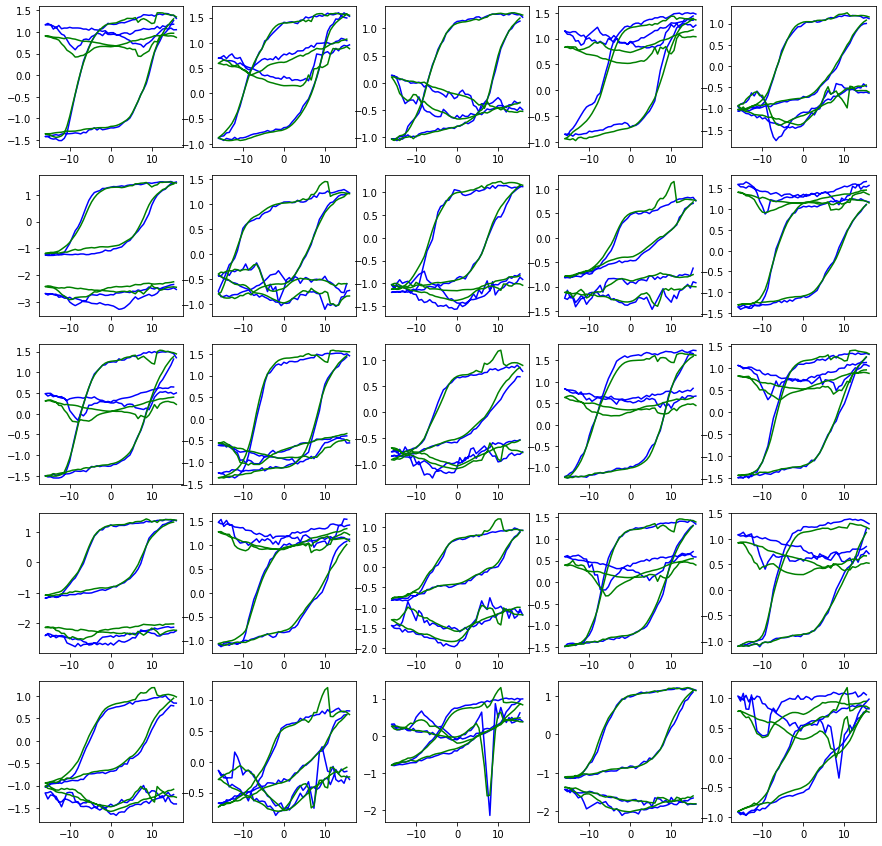

In [28]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, new_data.shape[0])
#        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
        ax.plot(vol,new_data[k],'b-')
        ax.plot(vol,out[k],'g-')

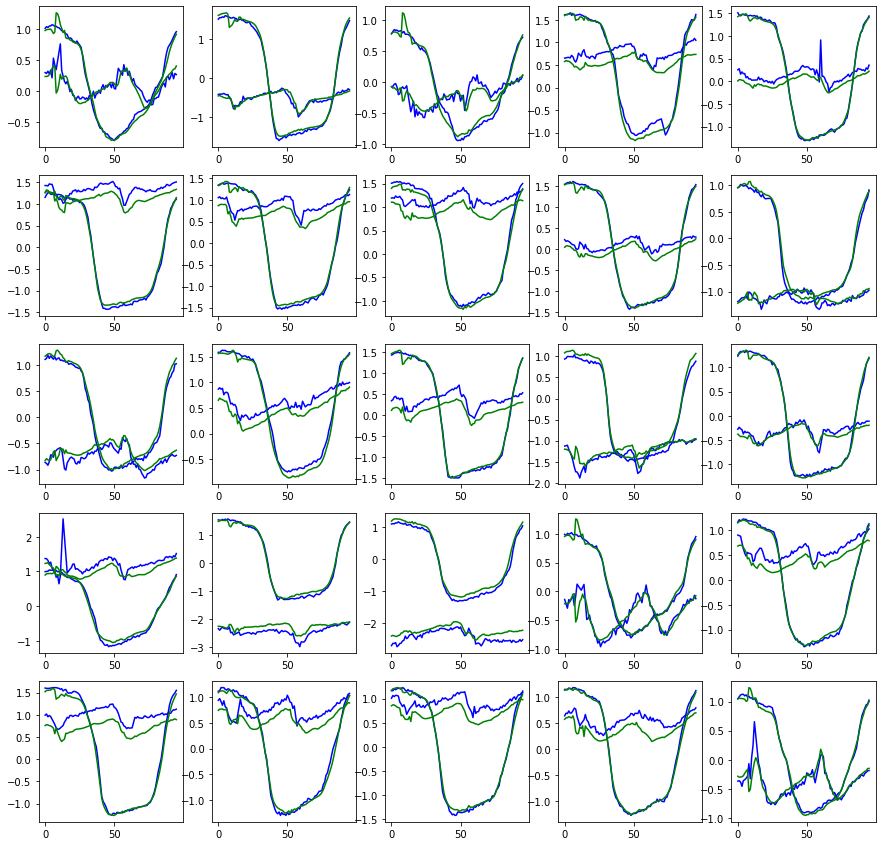

In [36]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, new_data.shape[0])
#        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
        ax.plot(new_data[k],'b-')
        ax.plot(out[k],'g-')

# Mean absolute error , beta=0-0.15

# Beta=0.1

In [31]:
model.vae.load_weights('beta=0.1__beta_step_siez=0.0025_16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/phase_shift_only0.1_epochs_begin_6000+40000+0754-0.11009.hdf5')

In [32]:
embedding = model.encoder_model.predict(np.atleast_3d(new_data))
out = model.vae.predict(np.atleast_3d(new_data))

In [33]:
print(mean_absolute_error(out[:,:,0].squeeze(), new_data[:,:,0].squeeze()))
print(mean_absolute_error(out[:,:,1].squeeze(), new_data[:,:,1].squeeze()))

0.08167403508209953
0.1453441642048995


2551
1112
1638
3094
3382
546
3513
284
1864
1540
1052
882
961
1409
534
1782
2732
68
1603
1847
3218
2024
3505
482
3136


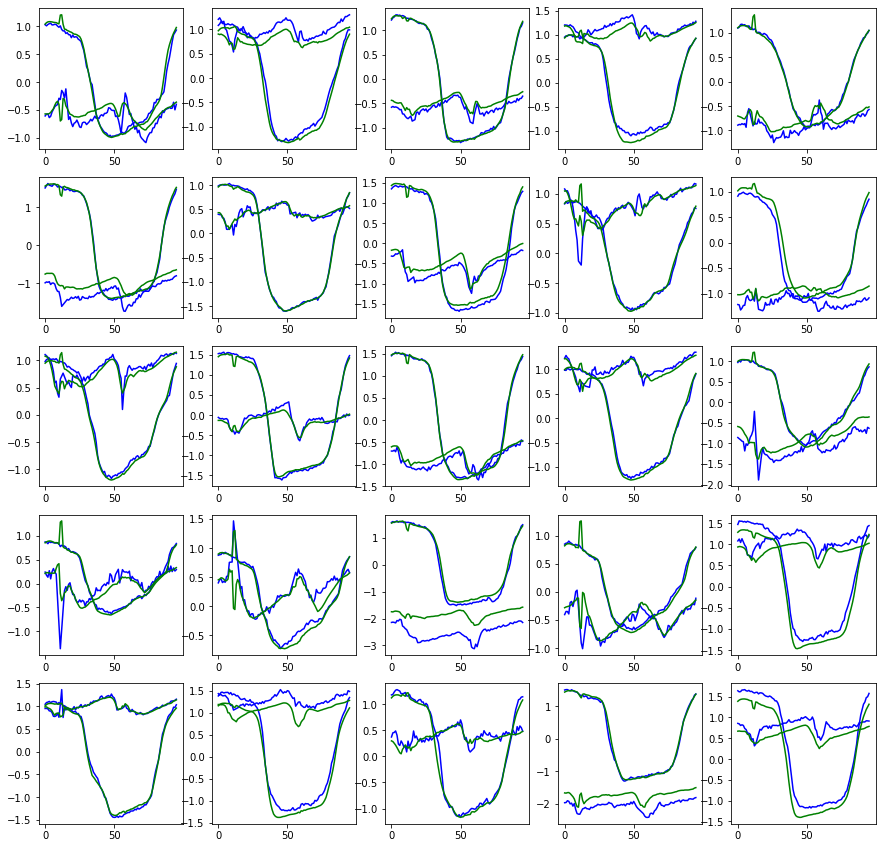

In [34]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, new_data.shape[0])
        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
        ax.plot(new_data[k],'b-')
        ax.plot(out[k],'g-')

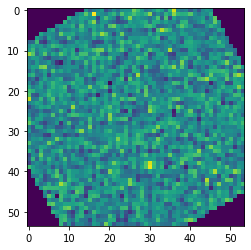

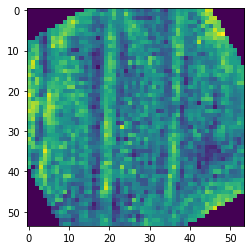

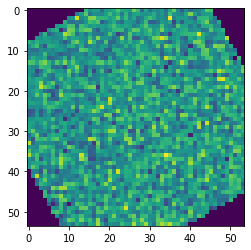

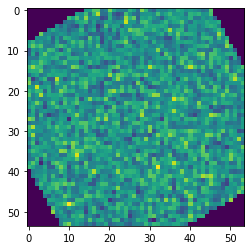

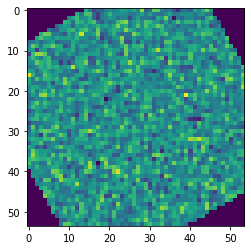

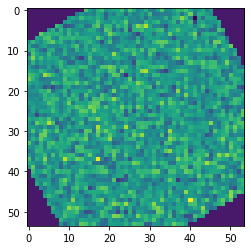

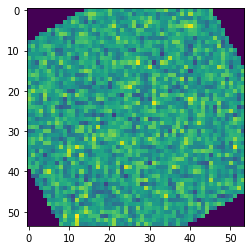

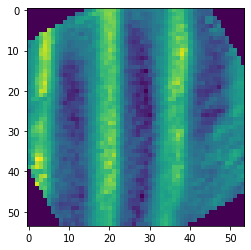

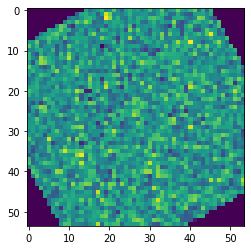

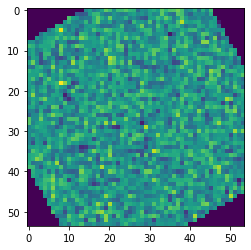

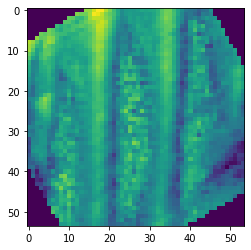

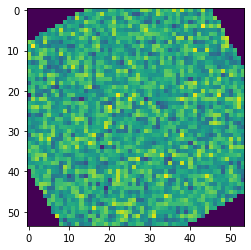

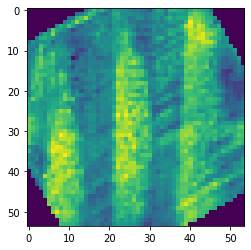

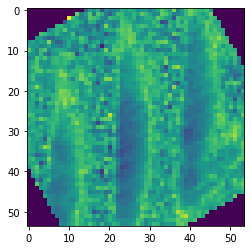

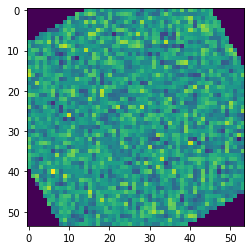

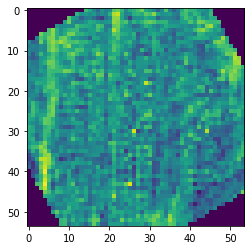

In [37]:
for i in range(16):
  plt.figure()
  img,scr=rotate_and_crop(embedding[:,i].reshape(60,60))
  plt.imshow(img)

# Beta=0.15

In [133]:
model.vae.load_weights('beta=0.0__beta_step_siez=0.0025_16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/phase_shift_only0.0_epochs_begin_0+5973-0.06432.hdf5')

In [134]:
embedding = model.encoder_model.predict(np.atleast_3d(new_data))
out = model.vae.predict(np.atleast_3d(new_data))

In [135]:
print(mean_absolute_error(out[:,:,0].squeeze(), new_data[:,:,0].squeeze()))
print(mean_absolute_error(out[:,:,1].squeeze(), new_data[:,:,1].squeeze()))

0.07054294376831584
0.08478602527628953


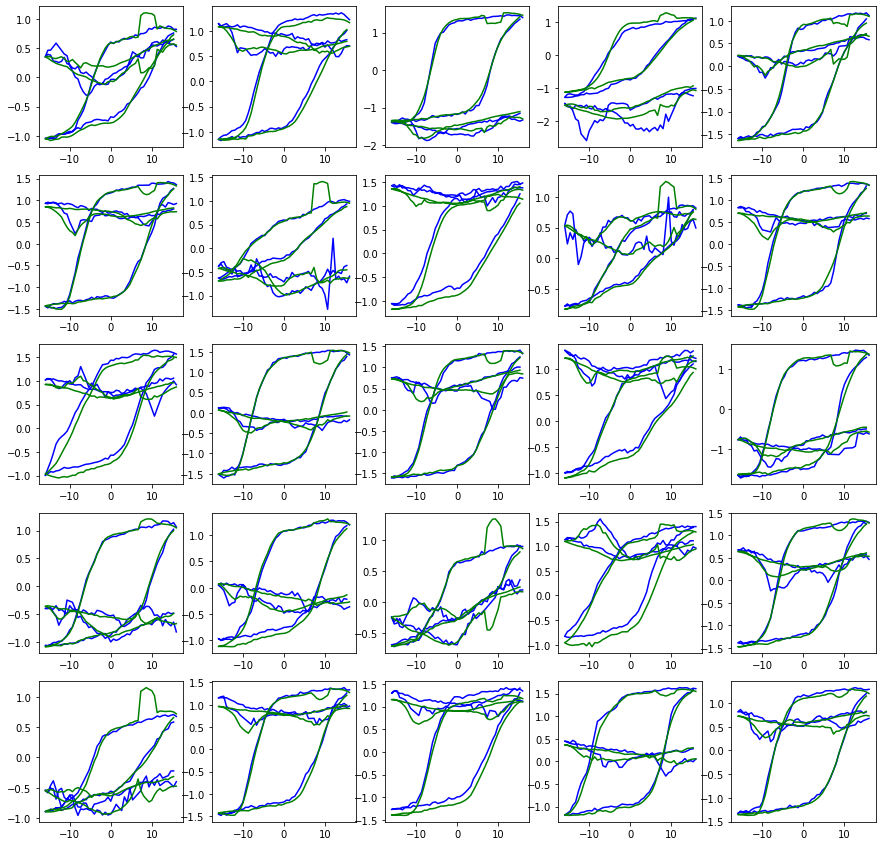

In [137]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, new_data.shape[0])
#        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
        ax.plot(vol,new_data[k],'b-')
        ax.plot(vol,out[k],'g-')

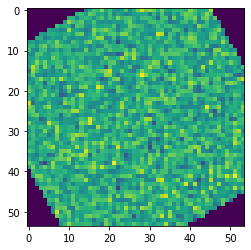

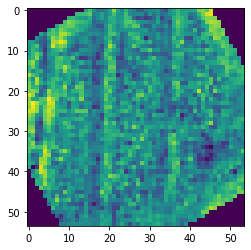

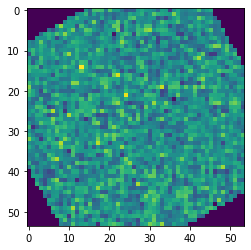

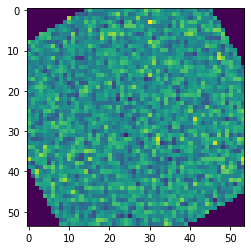

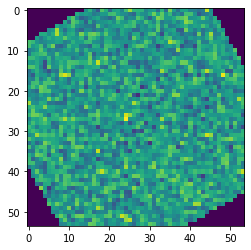

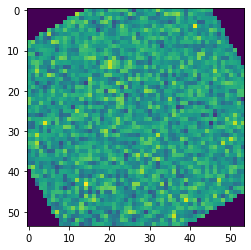

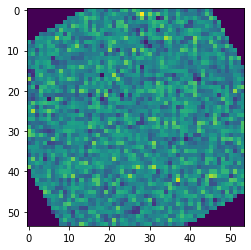

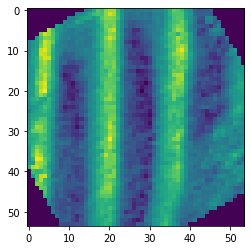

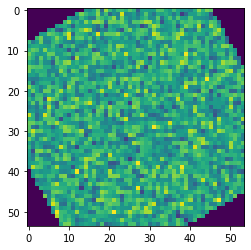

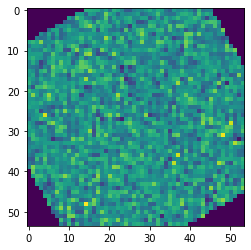

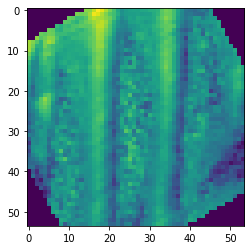

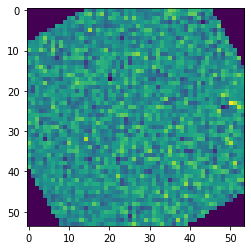

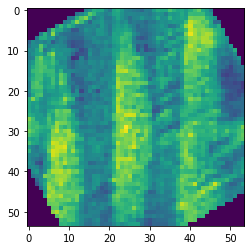

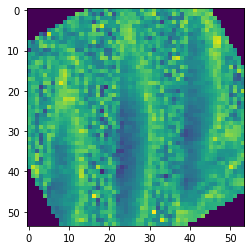

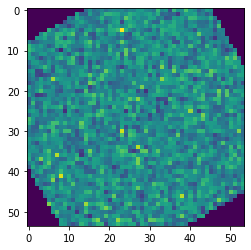

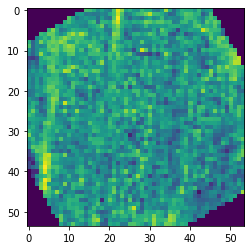

In [34]:
for i in range(16):
  plt.figure()
  img,scr=rotate_and_crop(embedding[:,i].reshape(60,60))
  plt.imshow(img)

In [72]:
pre_embedding =rnn.get_ith_layer_output(model.vae, np.atleast_3d(new_data), 28)

In [61]:
model.vae.layers[28]

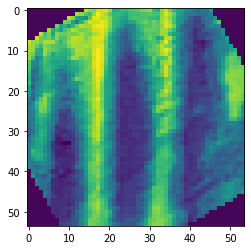

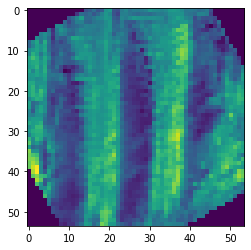

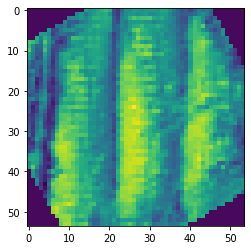

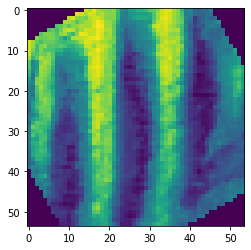

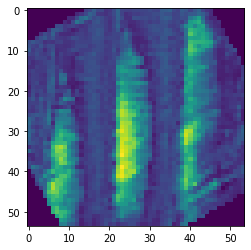

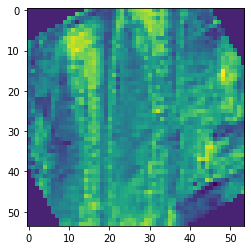

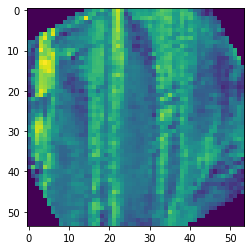

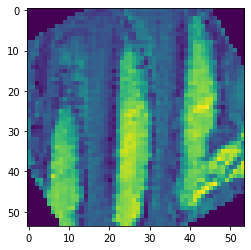

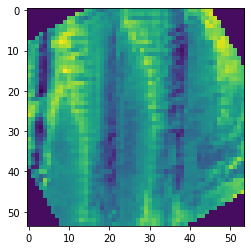

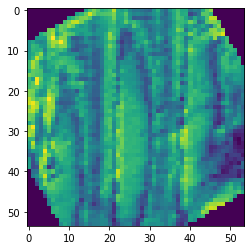

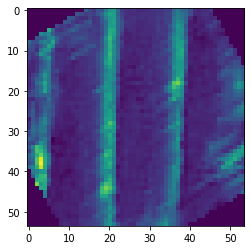

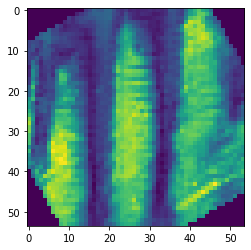

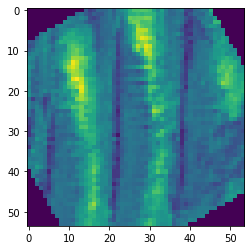

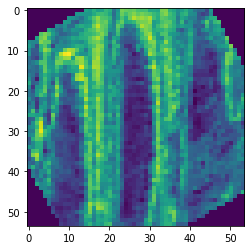

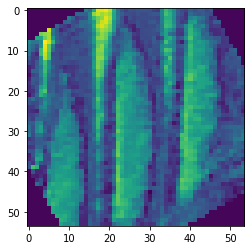

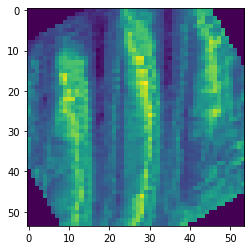

In [73]:
for i in range(16):
  plt.figure()
  img,scr=rotate_and_crop(pre_embedding[:,i].reshape(60,60))
  plt.imshow(img)

# add movie for each activated channel

In [44]:
cd ..

/home/shuyu/497_MAT_Assignment


In [45]:
cd piezoresponse+resonacnce_1/

/home/shuyu/497_MAT_Assignment/piezoresponse+resonacnce_1


In [35]:
folder_1 = make_folder('movie_for_embeddding_100_neighbour_with_bar_1')

In [ ]:
util.file.make_movie('absolute_error_movie_beta=0_0.15','beta_steep_size_0.0025_to_0.15_movie',
                     'beta_steep_size_0.0025_to_0.15_movie','png',4)

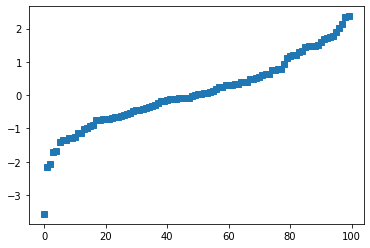

In [111]:
plt.plot(np.sort(np.random.normal(size=100)),'s')

In [125]:
gaus=np.sort(np.random.normal(size=100))

In [156]:
gaus[84]

1.001996762426393

In [157]:
gaus1=gaus[13:85]

In [159]:
gaus1[71]

1.001996762426393

In [ ]:
z = np.zeros((1,16))

In [102]:
def make_channel_movie(k):
    
    folder_1 = make_folder('movie_for_embeddding_'+str(k))
    z = np.zeros((1,16))

    for i in range(20):

        z = np.zeros((1,16))
        plt.figure(figsize=(10,10))

        if i<4:
            z[:,k] = np.linspace(-1,-0.5,4)[i]
            j=np.linspace(-1,-0.5,4)[i]
        elif i>15:
            z[:,k] = np.linspace(0.5,1,4)[i-16]
            j=np.linspace(0.5,1,4)[i-16]
        else:
            z[:,k] = np.linspace(-0.5,0.5,12)[i-4]
            j=np.linspace(-0.5,0.5,12)[i-4]
        if i<10:
            fig_name = '0'+str(i)+'_'+str(j)+'_embedding_'+str(k)+'_'
        else:
            
            fig_name = str(i)+'_'+str(j)+'_embedding_'+str(k)+'_'

        plt.plot(vol,model.decoder_model.predict(z).squeeze())
        plt.savefig(folder_1+'/'+fig_name+'.png')
    
    movie_name=str(k)+'_channel_movie'
    util.file.make_movie(movie_name,folder_1,
                     folder_1,'png',1)

Moviepy - Building video movie_for_embeddding_15/15_channel_movie.mp4.
Moviepy - Writing video movie_for_embeddding_15/15_channel_movie.mp4



Moviepy - Done !
Moviepy - video ready movie_for_embeddding_15/15_channel_movie.mp4


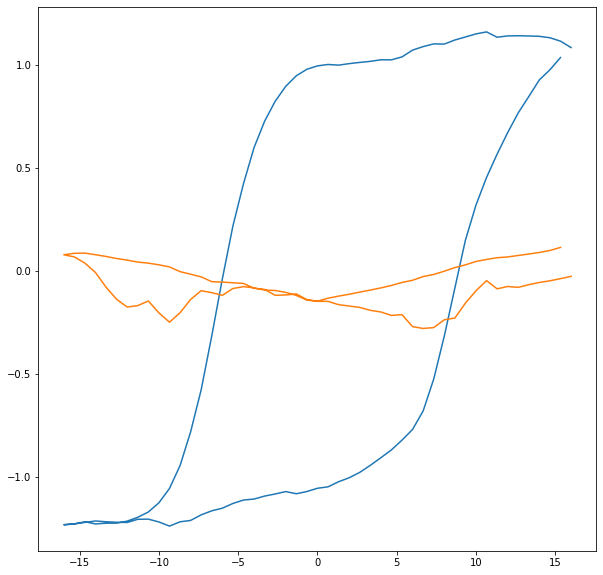

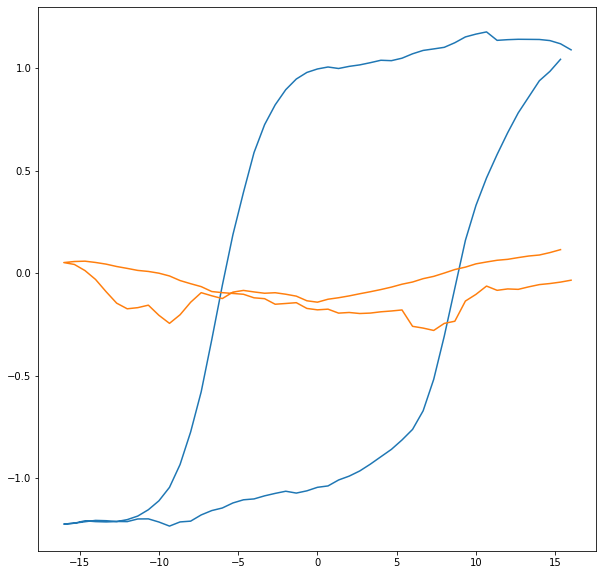

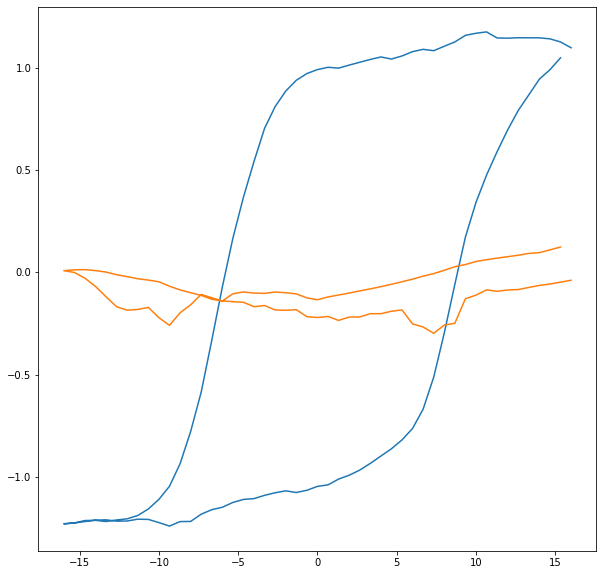

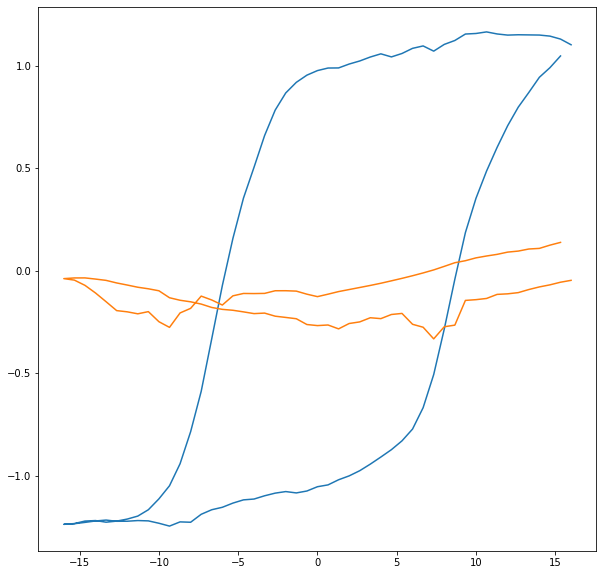

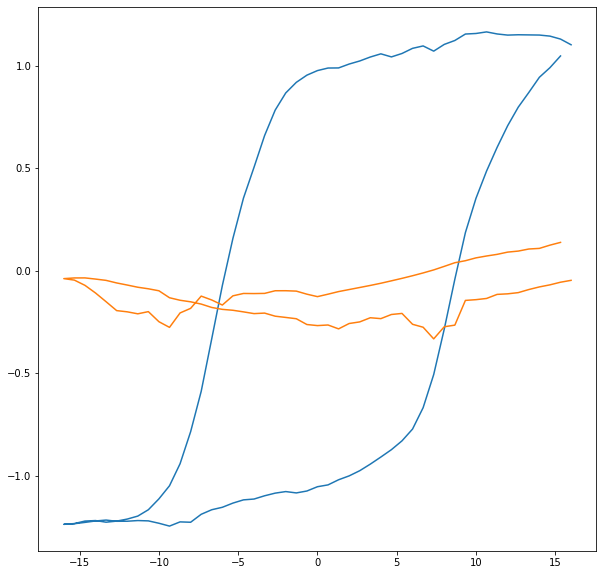

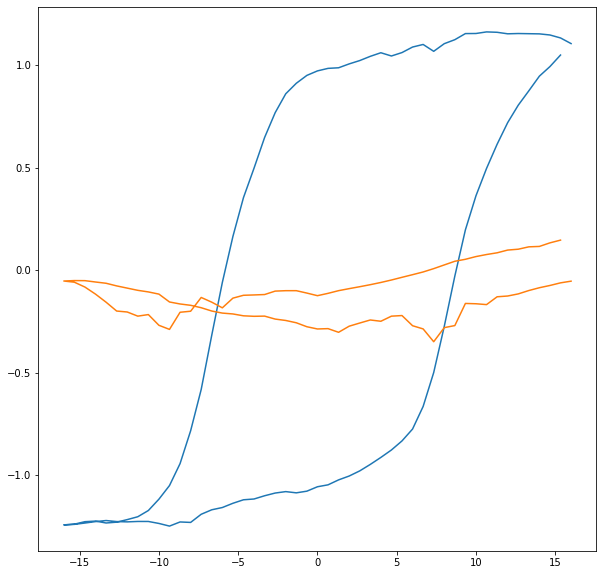

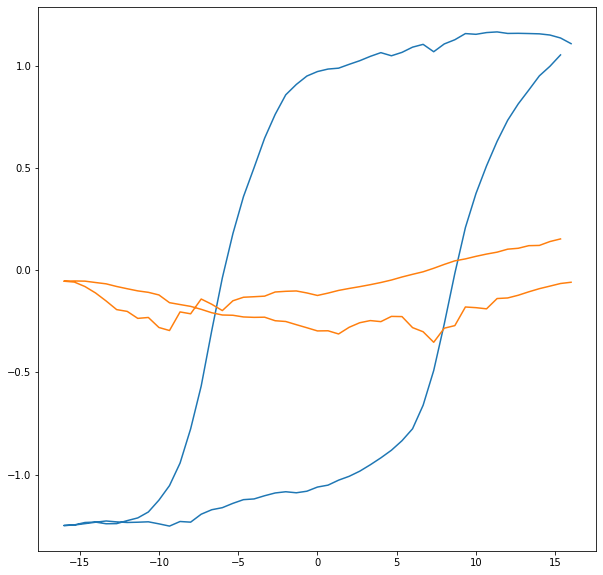

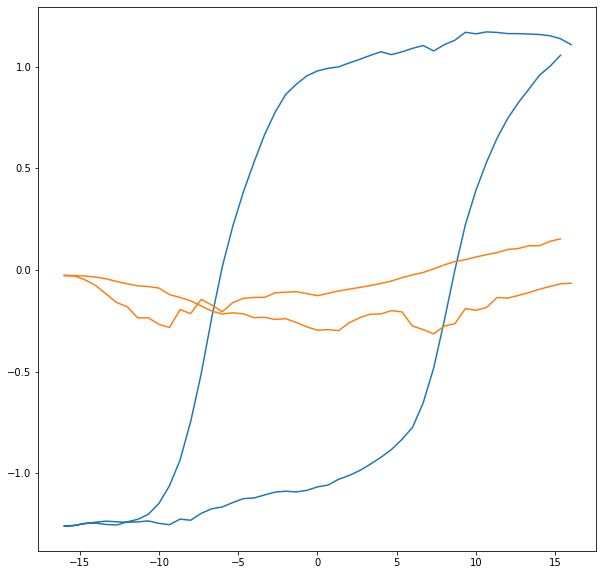

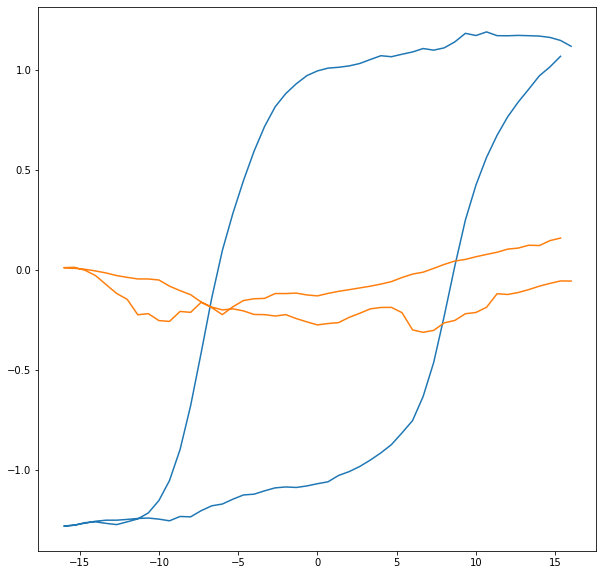

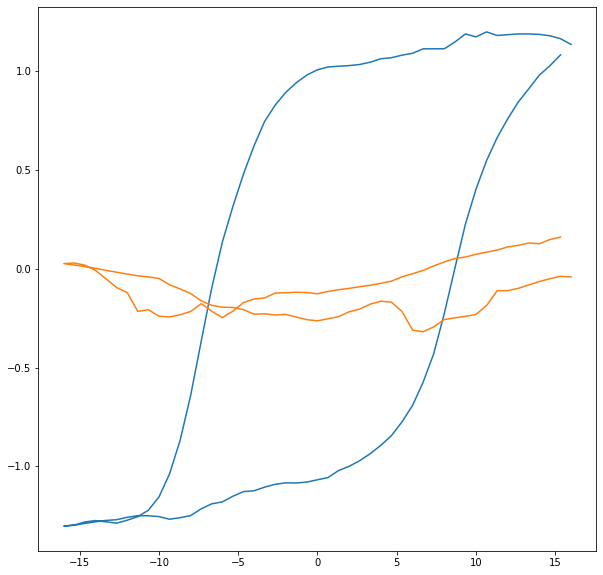

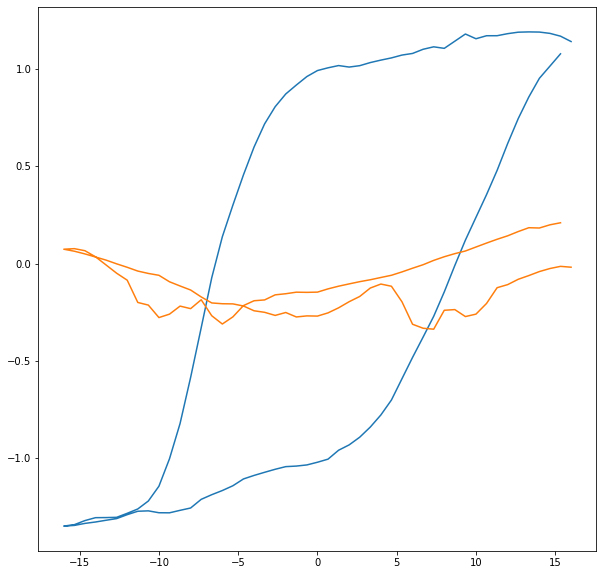

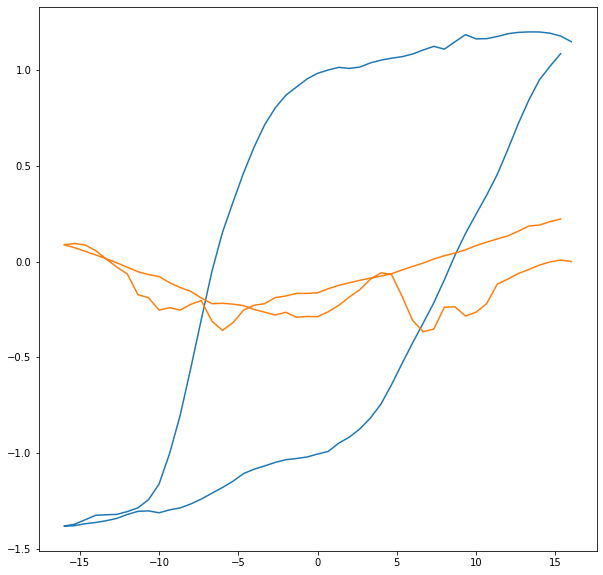

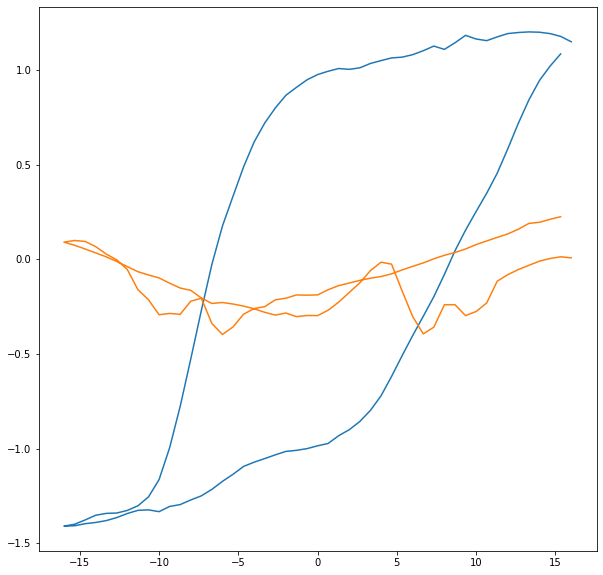

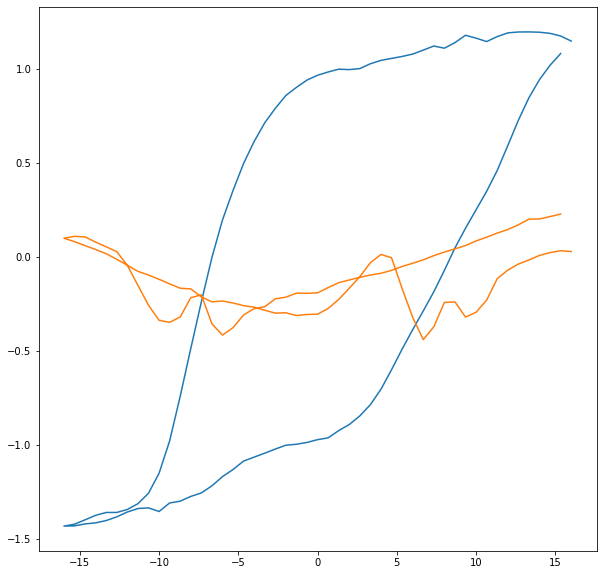

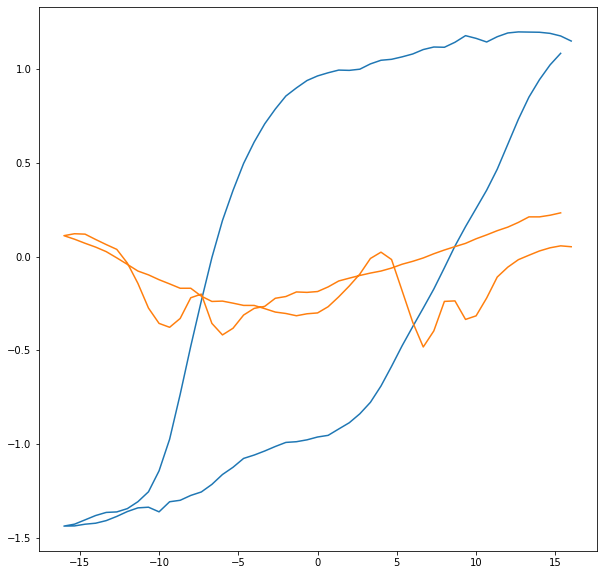

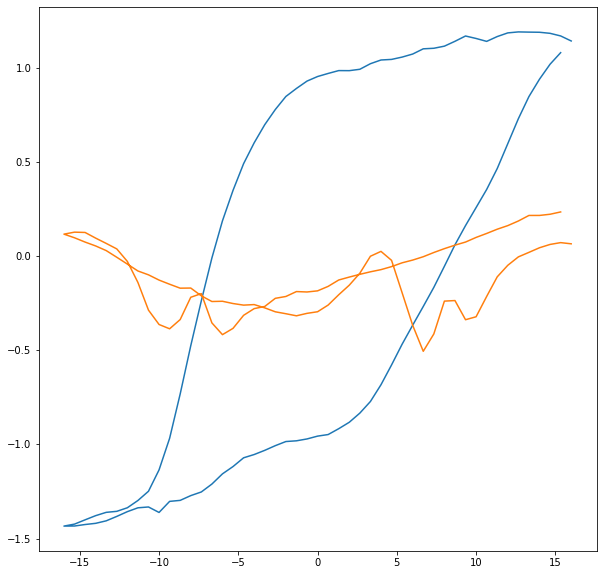

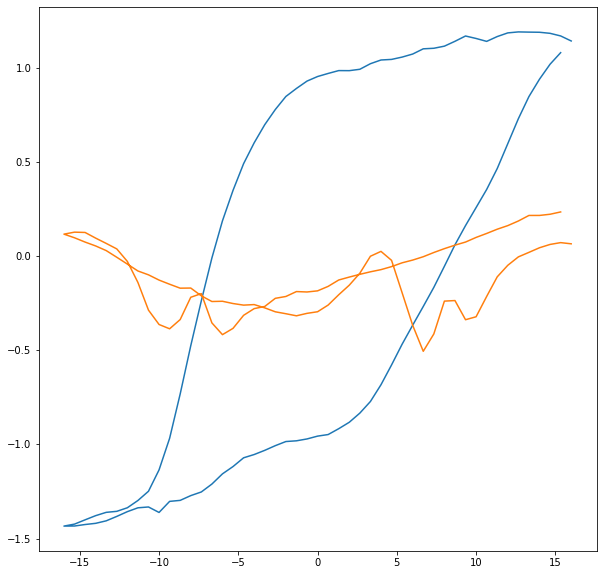

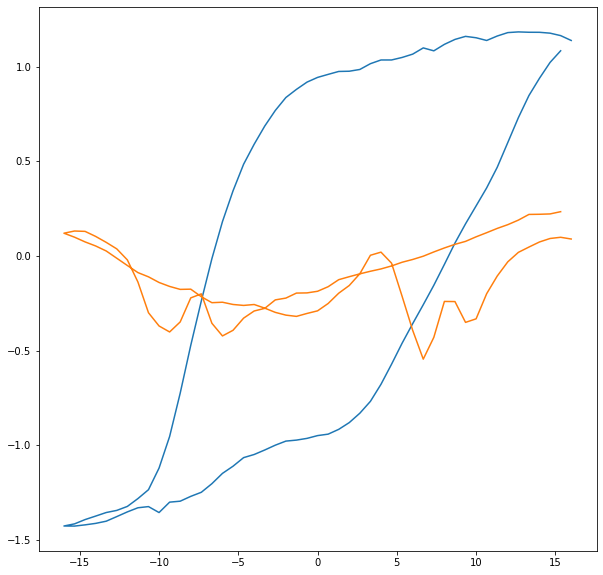

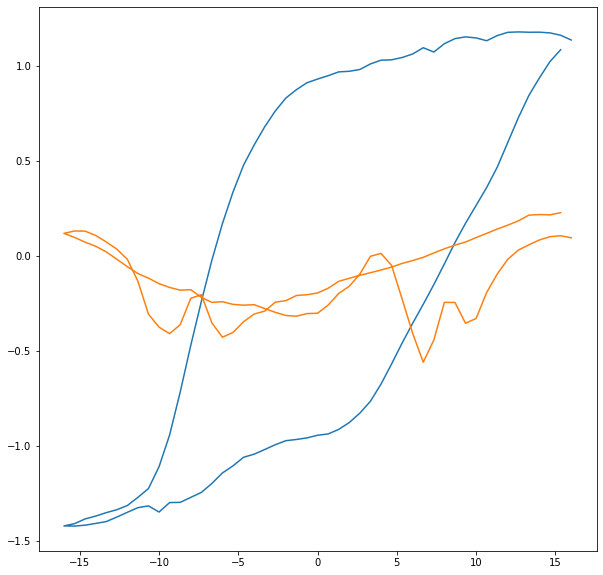

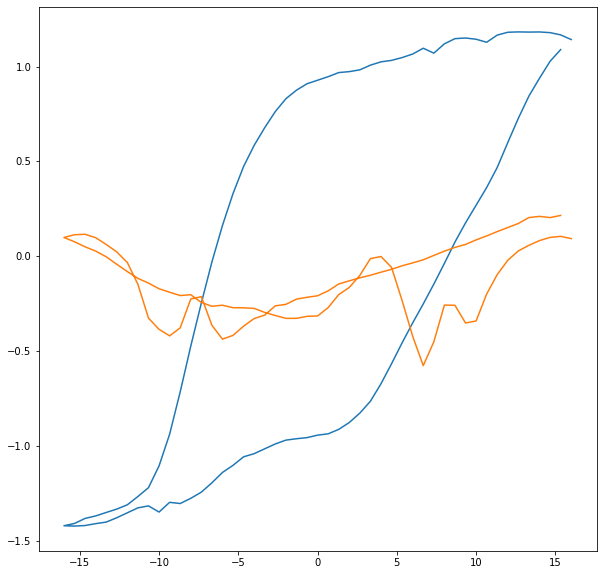

In [108]:
make_channel_movie(15)

In [83]:
np.linspace(-3,3,30)[20]

1.137931034482759

In [172]:
embedding.shape

(3600, 16)

In [43]:
def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image

    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find

    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import (pyplot as plt, path, patches)

In [29]:
def colorbar(axes, plot,
             location='right', size=10,
             pad=0.05, num_format='%.1e',
             ticks = True,
             label = False):

    # Adds the scalebar
    divider = make_axes_locatable(axes)
    cax = divider.append_axes(location, size='{0}%'.format(size), pad=pad)
    cbar = plt.colorbar(plot, cax=cax, format=num_format)

    if not ticks:
        cbar.set_ticks([])

    if isinstance(label, str):
        cbar.set_label(label, rotation=270, labelpad= 15)

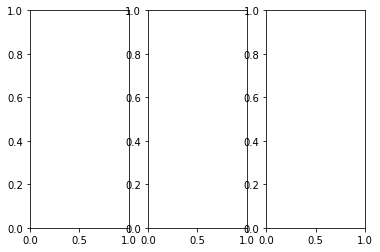

In [59]:
fig,axes = plt.subplots(1,3)

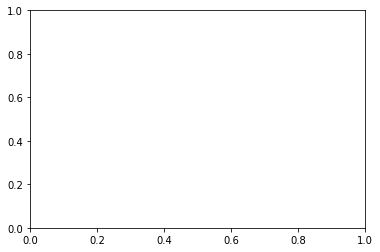

In [60]:
im = axes[1].imshow(embedding[:,1].reshape(60,60))
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='{0}%'.format(10), pad=0.05)
plt.colorbar(im, cax=cax, format='%.1e')

In [61]:
axes[1].imshow(embedding[:,1].reshape(60,60))
fig.show()

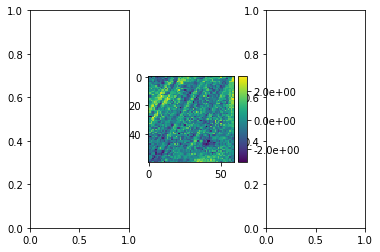

In [62]:
fig

In [97]:
ind = find_nearest(embedding[:,1],-1,50)
ind1 = find_nearest(embedding[:,1],-0.95,50)

In [99]:
print(ind)
print(ind1)

[1812 2045  446  444 1295 2305 2163  947 3015 2002 2925 2348 1375 3091
 2825 1757 2743 1249  317 2609  188 1236 2517 1779 3333 1659   79 1971
 1911 1758  702 2364 2220 1546 3188 2621 2506  504 2843 3300  953  450
 1892 3060 2406 1946 1639  233 3197 3542]
[ 507 1075 1816 1283 1053 3209 1171 1549  829 1563 1467 2744 2424 2955
 1780 1580  189 2333 2194 3554 1214  127 2062 1428 1043 2642  806 2190
 3598 3542 3197 1639 1946 2406 3060 2371  450  953 3300 2506 2621 1222
 3188 2144 2878 3121 2220  702  197  526]


-0.8911414

In [100]:
gen_value = np.mean(embedding[ind], axis=0)
gen_value1 = np.mean(embedding[ind1], axis=0)

In [101]:
print(gen_value)
print(gen_value1)

[ 0.18211754 -0.99623126  0.14323491  0.18912801  0.08497594 -0.03468768
 -0.10482888 -0.0568871   0.03426995  0.15626626  0.12825419 -0.02824172
  0.48790213  0.26305574 -0.21992172  0.0297716 ]
[-0.20013744 -0.9526051   0.14870605  0.09878527  0.18909729 -0.10699911
 -0.3438574   0.01163566 -0.04433301 -0.1612286   0.12528421 -0.19779465
  0.327543    0.31253535 -0.22998151 -0.11010126]


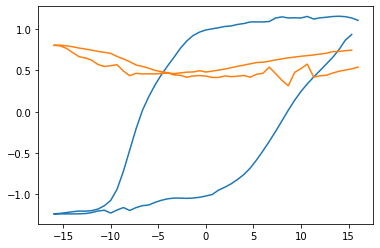

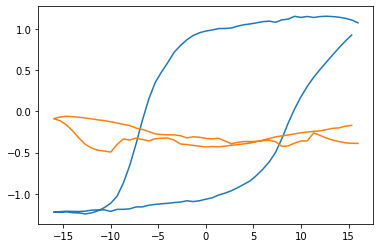

In [104]:
plt.figure()
plt.plot(vol,model.decoder_model.predict(np.atleast_2d(gen_value)).squeeze())
plt.figure()
plt.plot(vol,model.decoder_model.predict(np.atleast_2d(gen_value1)).squeeze())

In [127]:
ind2 = find_nearest(embedding[:,7],0.3,50)
ind3 = find_nearest(embedding[:,7],0.25,50)
print(ind2)
print(ind3)

[1026 1409 2616 2566  597 2252 2292 1805 2691 2014 3202  660 2989 2923
 1401 3164 3107  221 2808  908  299  662 1132 3458 1785   16 1341  985
  203  107 3044 3412 3457 1183 2074 2864 2510 3182 3012  656 2775  737
 1706  960   76   26 3350 1539 1077 1421]
[3599 1163 3538 3024 3288 1302 2854 2983 3592 3102 3456 1282  827 1142
 2953 1004 2708 2984 3150 2726 3487  399  688 1400 2518  272   53 1045
 3564  577 2801 2336 2692  706 2565  669 2397  421 2529 2786 2632 3469
 1757 2538 2459 2579  470 2574 3064  292]


In [128]:
gen_value2 = np.mean(embedding[ind2], axis=0)
gen_value3 = np.mean(embedding[ind3], axis=0)

In [129]:
print(gen_value2)
print(gen_value3)

[ 0.02142364  0.2168099   0.11779497  0.05992619  0.05353081  0.09529918
 -0.00778567  0.30064002  0.1555005  -0.00803629  0.03384827 -0.11704107
  0.24691834  0.39080998 -0.143194   -0.11434685]
[-0.21642666 -0.3082689   0.12361714 -0.00855344  0.13353118 -0.09409557
 -0.14676207  0.24946731 -0.12504987  0.40438396 -0.08317956  0.02173271
  0.04411172  0.06574223  0.21169554 -0.25419492]


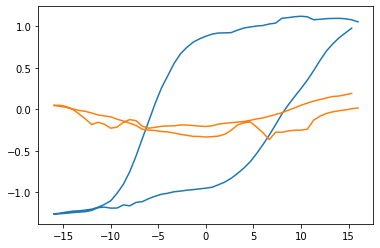

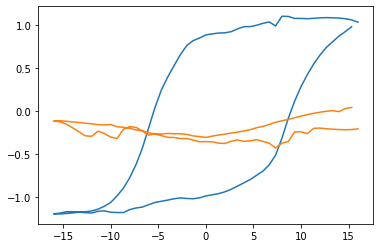

In [130]:
plt.figure()
plt.plot(vol,model.decoder_model.predict(np.atleast_2d(gen_value2)).squeeze())
plt.figure()
plt.plot(vol,model.decoder_model.predict(np.atleast_2d(gen_value3)).squeeze())


In [131]:
new_val = np.mean(embedding,axis=0)

In [132]:
new_val.shape

(16,)

In [121]:
embedding[:,1].shape

(3600,)

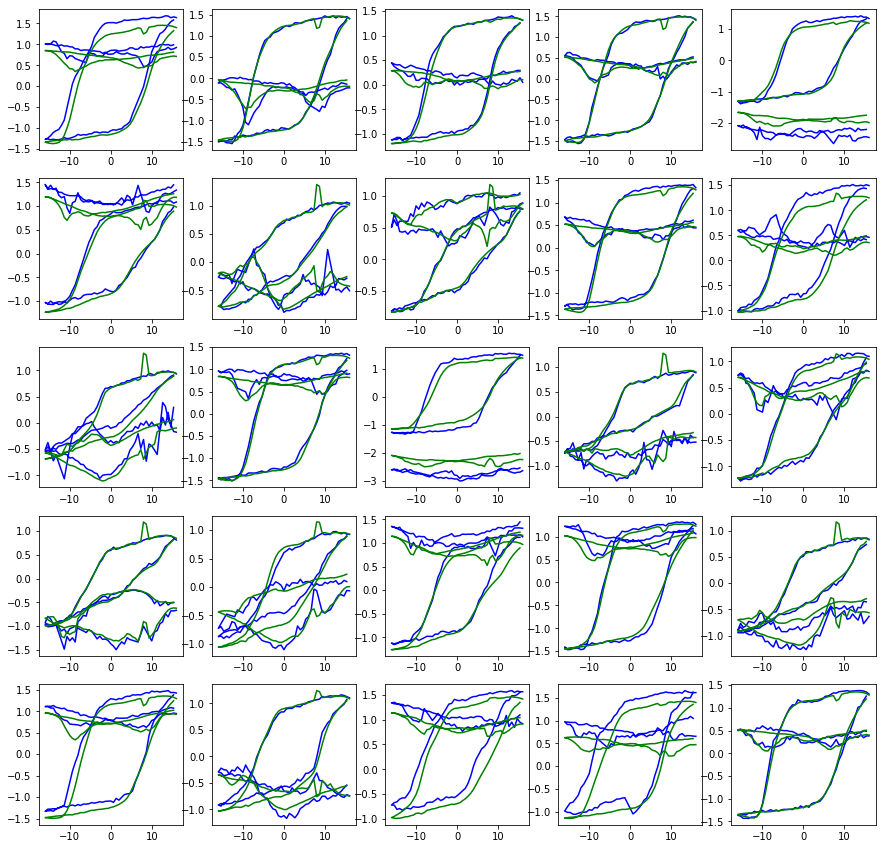

In [123]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, new_data.shape[0])
#        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
        ax.plot(vol,new_data[k],'b-')
        ax.plot(vol,model.decoder_model.predict(np.atleast_2d(embedding[k])).squeeze(),'g')

In [65]:
def make_new_movie(List1,gaus,embedding,neighbour):
    lenL = len(List1)
    for i in range(len(gaus)):
        fig, ax = layout_fig(lenL*2,lenL)
        
        for j in range(lenL):    
            
            img,scr=rotate_and_crop(embedding[:,List1[j]].reshape(60,60))
                
            im = ax[j].imshow(img)
            
            if j==lenL-1:
                
                divider = make_axes_locatable(ax[j])
                cax = divider.append_axes('right', size='{0}%'.format(10), pad=0.05)
                plt.colorbar(im, cax=cax, format='%.1e')

            idx = find_nearest(embedding[:,List1[j]],gaus[i],neighbour)
            gen_value = np.mean(embedding[idx],axis=0)
            gen_value[List1[j]]=gaus[i]
#            z[:,List1[j]] = gaus[i] # nearest 10 neighbour
            
            ax[j+lenL].plot(vol,model.decoder_model.predict(np.atleast_2d(gen_value)).squeeze())
            ax[j+lenL].set_ylim([-1.6, 1.6])
        
        if i<10:
            fig_name = '00'+str(i)+'_'+str(gaus[i])+'_embedding_'
            
        elif i>=10 and i<100:
            fig_name = '0'+str(i)+'_'+str(gaus[i])+'_embedding_'
            
        else:
            
            fig_name = str(i)+'_'+str(gaus[i])+'_embedding_'

        fig.savefig(folder_1+'/'+fig_name+'.png')   


In [66]:
List1=[1,7,10,12,13,15]

In [67]:
lin = np.linspace(-1,1,1000)

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

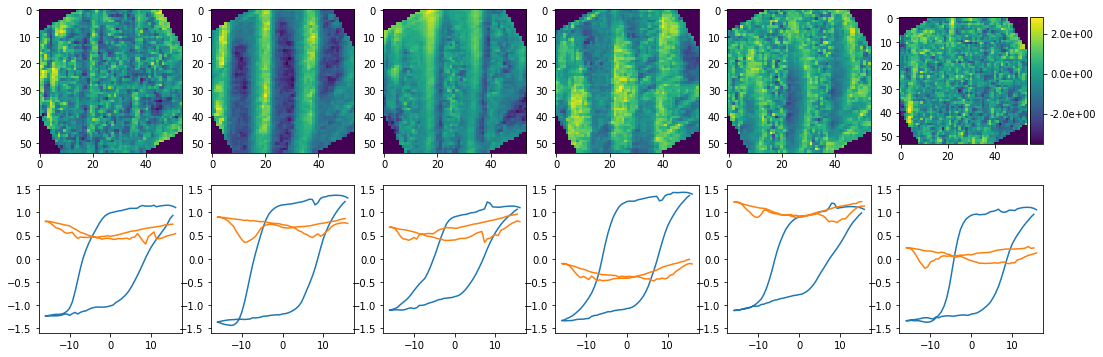

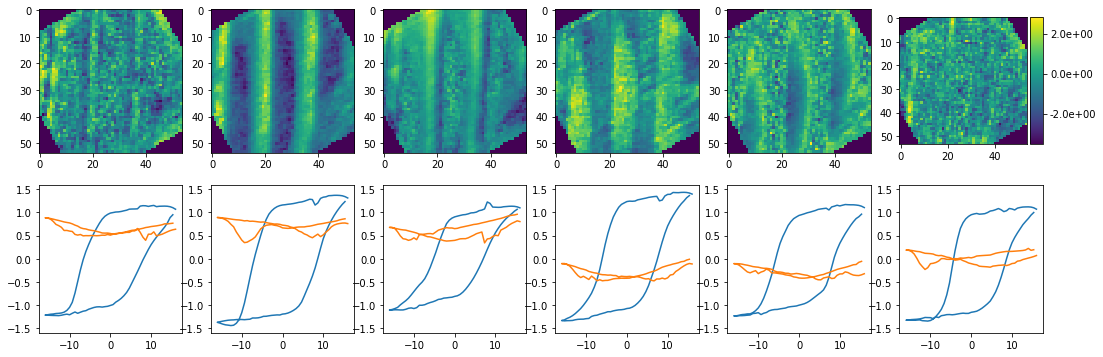

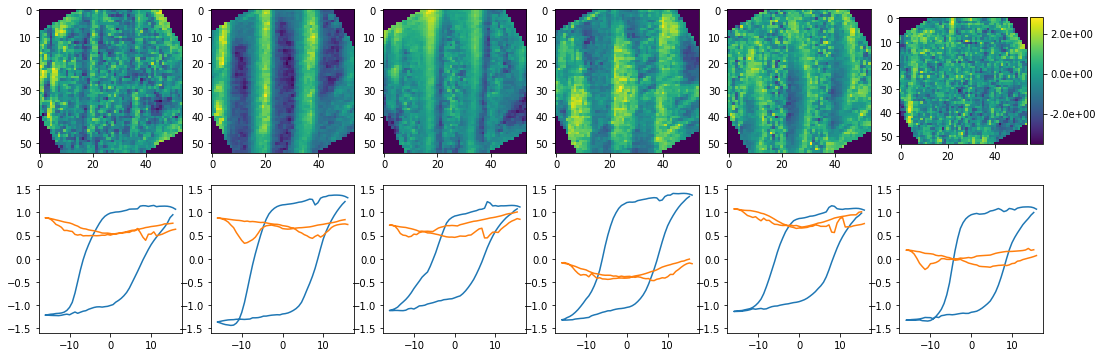

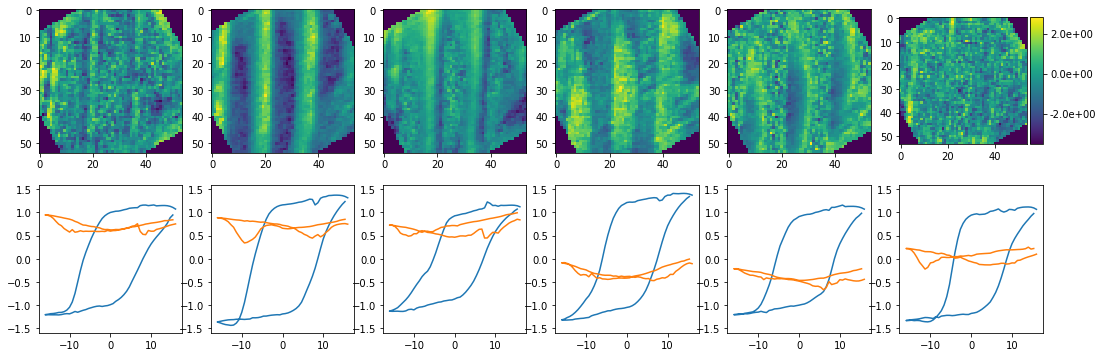

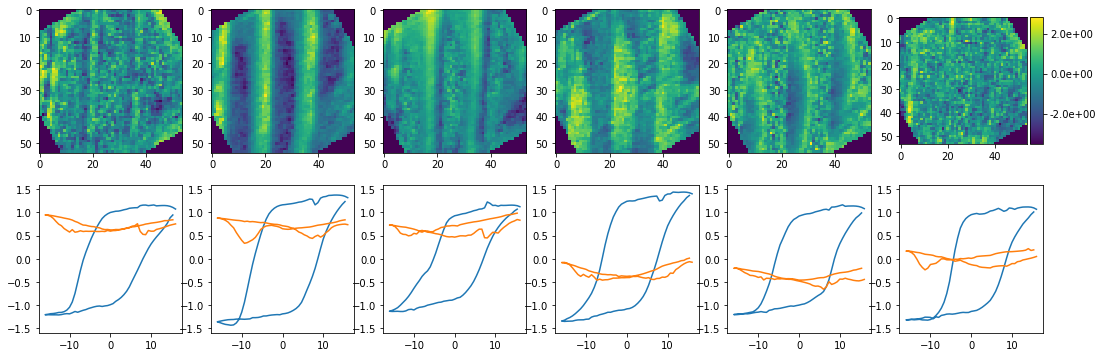

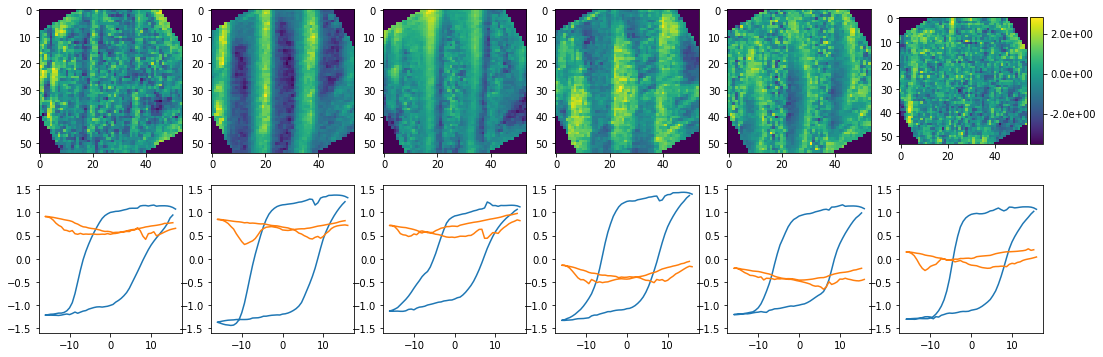

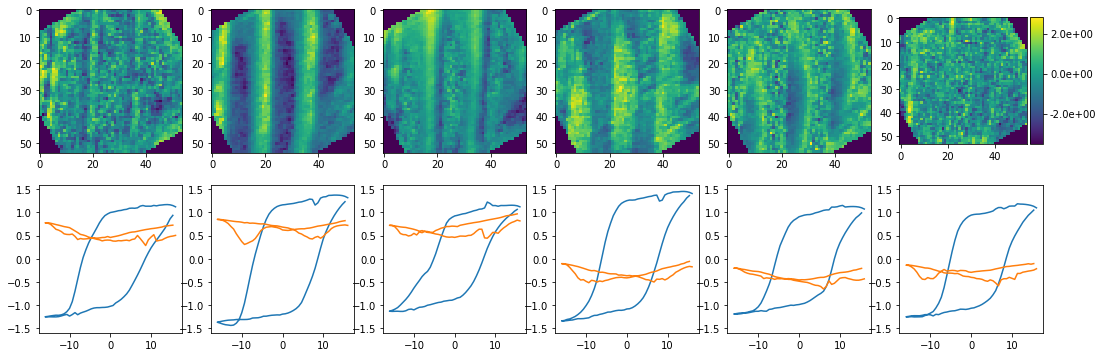

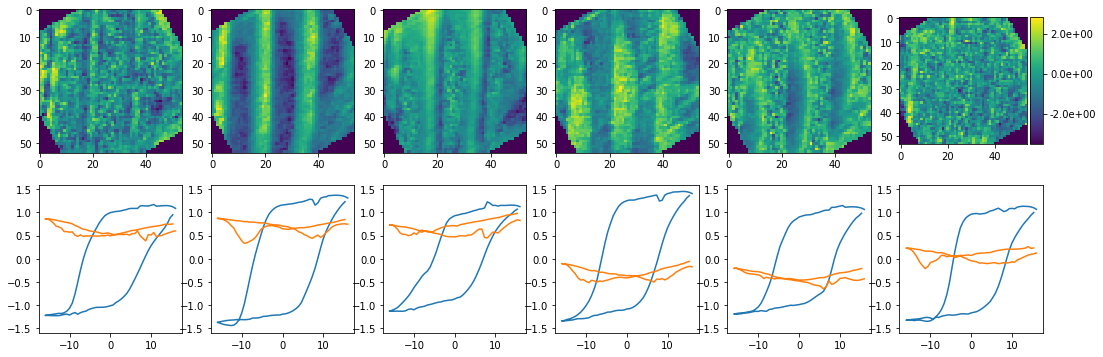

Error in callback <function flush_figures at 0x7f6dd81b5cb0> (for post_execute):


KeyboardInterrupt: 

In [89]:
make_new_movie(List1,lin,embedding,50)

In [90]:
util.file.make_movie('new_movie_linear_1',folder_1,
                     folder_1,'png',5)

Moviepy - Building video movie_for_embeddding_100_neighbour_with_bar_1/new_movie_linear_1.mp4.
Moviepy - Writing video movie_for_embeddding_100_neighbour_with_bar_1/new_movie_linear_1.mp4



Moviepy - Done !
Moviepy - video ready movie_for_embeddding_100_neighbour_with_bar_1/new_movie_linear_1.mp4


In [31]:
def rotate_and_crop(image_, angle=60.46, frac_rm=0.17765042979942694):
    """
    Function which rotates and crops the images

    Parameters
    ----------
    image_ : array
        image array to plot
    angle  : float, optional
        angle to rotate the image by
    frac_rm  : float, optional
        sets the fraction of the image to remove

    Returns
    ----------
    crop_image : array
        image which is rotated and cropped
    scale_factor : float
        scaling factor for the image following rotation
    """
    # makes a copy of the image
    image = np.copy(image_)
    # replaces all points with the minimum value
    image[~np.isfinite(image)] = np.nanmin(image)
    # rotates the image
    rot_topo = ndimage.interpolation.rotate(
        image, 90-angle, cval=np.nanmin(image))
    # crops the image
    pix_rem = int(rot_topo.shape[0]*frac_rm)
    crop_image = rot_topo[pix_rem:rot_topo.shape[0] -
                          pix_rem, pix_rem:rot_topo.shape[0]-pix_rem]
    # returns the scale factor for the new image size
    scale_factor = (np.cos(np.deg2rad(angle)) +
                    np.cos(np.deg2rad(90-angle)))*(1-frac_rm)

    return crop_image, scale_factor

In [32]:
embedding.shape

(3600, 16)

In [33]:
def layout_fig(graph, mod=None):

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
            
        mod = graph//2

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

# Mean Absolute Loss 

In [37]:
cd ..

/home/shuyu/497_MAT_Assignment


In [38]:
cd piezoresponse+resonacnce/

/home/shuyu/497_MAT_Assignment/piezoresponse+resonacnce


/home/shuyu/497_MAT_Assignment


In [39]:
import codes_pie_res.analysis.rnn as rnn
import codes_pie_res.util as util
import codes_pie_res.analysis.machine_learning as ml
import codes_pie_res.analysis as an
import codes_pie_res.processing as p
import codes_pie_res.viz as viz
import codes_pie_res.util.input_output as io_transfer

Using TensorFlow backend.


In [40]:
# builds folders where the data will be saved
folder_structure = util.file.make_folder(
    './structure')
folder_BE = util.file.make_folder(
    './Band_Excitation')
folder_BE_Movie_files = util.file.make_folder(
    folder_BE + '/BE_Movie_Files')
folder_BE_all_images = util.file.make_folder(
    folder_BE + '/BE_all_images')
folder_BE_spectra = util.file.make_folder(
    folder_BE + '/BE_spectra')
folder_BE_cleaned_spectra = util.file.make_folder(
    folder_BE + '/cleaned_spectra')
folder_pca = util.file.make_folder(
    './pca')
folder_nmf = util.file.make_folder(
    './nmf')
folder_clustering = util.file.make_folder('./clustering')
folder_pca_clustering = util.file.make_folder(
    './pca_clustering')
folder_piezoresponse_autoencoder = util.file.make_folder(
    './piezoresponse_autoencoder')
folder_resonance_autoencoder = util.file.make_folder(
    './resonance_autoencoder')
folder_piezoresponse_autoencoder_movie = util.file.make_folder(
    folder_piezoresponse_autoencoder + '/movie')
folder_piezoresponse_autoencoder_training_movie = util.file.make_folder(
    folder_piezoresponse_autoencoder + '/training_movie')
folder_resonance_autoencoder_movie = util.file.make_folder(
    folder_resonance_autoencoder + '/movie')
folder_resonance_autoencoder_training_movie = util.file.make_folder(
    folder_resonance_autoencoder + '/training_movie')
folder_phase_field = util.file.make_folder(
    './Phase_Field')

In [41]:
plot_format = {
    # adds scalebar to image
    'add_scalebar': False,
    'just_try': [2000, 500],
    # sets the dimensions for the scalebar [(size of image),(size of scalebar)]
    'scalebar': [2000, 500],
    # selects if the image will be rotated
    'rotation': False,
    # selects the rotation angle of the image
    'angle': 60.46,
    # sets the fraction of the image to crop
    'frac_rm': 0.17765042979942694,
    # sets the resolution of the image
    'dpi': 300,
    # sets the default colormap
    'color_map': 'viridis',
    # sets if color bars should be added
    'color_bars': True}

In [42]:
# Sets what object to export
printing = {  # exports eps vector graphics (note these files can be large)
    'EPS': False,
    # exports png files
    'PNG': True,
    # prints image series (note this can take some time)
    'all_figures': False,
    # generates movies (note this can take some time)
    'movies': False,
    # resolution of the images
    'dpi': 300}

In [26]:
beta = 0

model_ = model_builder(np.atleast_3d(new_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-5,coef=beta)

In [25]:
new_data.shape

(3600, 96, 2)

In [26]:
model_.vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 2)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 192)          0           input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 192)       0           flatten[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 192, 1)       0           repeat_vector[0][0]              
________________________________________________________________________________________________

In [138]:
model_folder = 'beta=0.99_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True'

In [40]:
import os
folder_ = make_folder('beta_steep_size_0.0025_to_0.15_movie')

In [35]:
58*25/10000

0.145

In [197]:
cd ..

/home/shuyu/497_MAT_Assignment


In [198]:
cd piezoresponse+resonacnce_1/

/home/shuyu/497_MAT_Assignment/piezoresponse+resonacnce_1


In [71]:
folder_ = make_folder('beta_mse_movie')

In [42]:
for i in range(58,61):
    j=i*25/10000
    model_folder = 'beta='+str(j)+'__beta_step_siez=0.0025_16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True'
    if i <10:
        file_name = '0'+str(i)+ '_beta='+str(j)
    else:
        
        file_name = str(i)+'_beta='+str(j)
    viz.plot.training_images(model_.vae,
                    new_data,
                    model_folder,
                    printing,
                    plot_format,
                    folder_,
                    file_name)

In [43]:
util.file.make_movie('absolute_error_movie_beta=0_0.15','beta_steep_size_0.0025_to_0.15_movie','beta_steep_size_0.0025_to_0.15_movie','png',4)

Moviepy - Building video beta_steep_size_0.0025_to_0.15_movie/absolute_error_movie_beta=0_0.15.mp4.
Moviepy - Writing video beta_steep_size_0.0025_to_0.15_movie/absolute_error_movie_beta=0_0.15.mp4



Moviepy - Done !
Moviepy - video ready beta_steep_size_0.0025_to_0.15_movie/absolute_error_movie_beta=0_0.15.mp4


In [38]:
i=83
j=i/100
model_folder = 'beta='+str(j)+'_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True'
file_name = 'beta='+str(j)
viz.plot.training_images(model_.vae,
                new_data,
                model_folder,
                printing,
                plot_format,
                folder_,
                file_name)

In [153]:
np.atleast_2d(new_embedding[0]).shape

(1, 2)

In [159]:
np.array([[1,2]]).shape

(1, 2)

In [154]:
try_1=model_1.decoder_model.predict(np.atleast_2d(new_embedding[0]))

In [155]:
try_1.shape

(1, 96, 2)

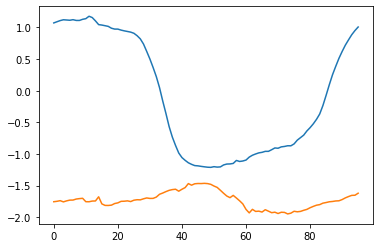

In [157]:
plt.plot(try_1[0])

In [ ]:
np.zeros(1,16)

In [29]:
beta = 0

model_2 = model_builder(np.atleast_3d(new_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-5,coef=beta)

In [31]:
np.zeros([1,16]).shape

(1, 16)

In [39]:
cd piezoresponse+resonacnce/

/home/shuyu/497_MAT_Assignment/piezoresponse+resonacnce


In [41]:
model_2.vae.load_weights('beta=0.5_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_1e-05_VAE_True/phase_shift_only0.5_epochs_begin_25000+0264-0.11434.hdf5')

In [34]:
cd ..

/home/shuyu/497_MAT_Assignment


In [35]:
vol = np.load('voltage.npy')

In [32]:
beta = 0

model_1 = model_builder(np.atleast_3d(new_data),embedding=2, 
              VAE=True, l1_norm_embedding=1e-5,coef=beta)

In [33]:
model_1.decoder_model.load_weights('only_with_decoder_3500+_/phase_shift_only_epochs_3500++27925-0.18855.hdf5')

In [52]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 10
#    digit_size = 28
    scale = 1.0
    fsize = 15
#    figure = np.zeros((digit_size * n, digit_size * n))
    fig, axs = plt.subplots(n, n, figsize=(fsize, fsize))
    axs.reshape(-1)
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            ax = axs[i,j]
#            z_sample = np.array([[xi, yi]])
            z_sample = np.zeros([1,16])
            z_sample[:,1]=xi
            z_sample[:,7]=yi
            x_decoded = decoder.predict(z_sample)
#            digit = x_decoded[0].reshape(digit_size, digit_size)
            ax.plot(vol,x_decoded[0,:,1])
    plt.figure(figsize=(fsize, fsize))
#    start_range = digit_size // 2
#    end_range = n * digit_size + start_range + 1
#    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
#     plt.imshow(fig)
#     plt.show()




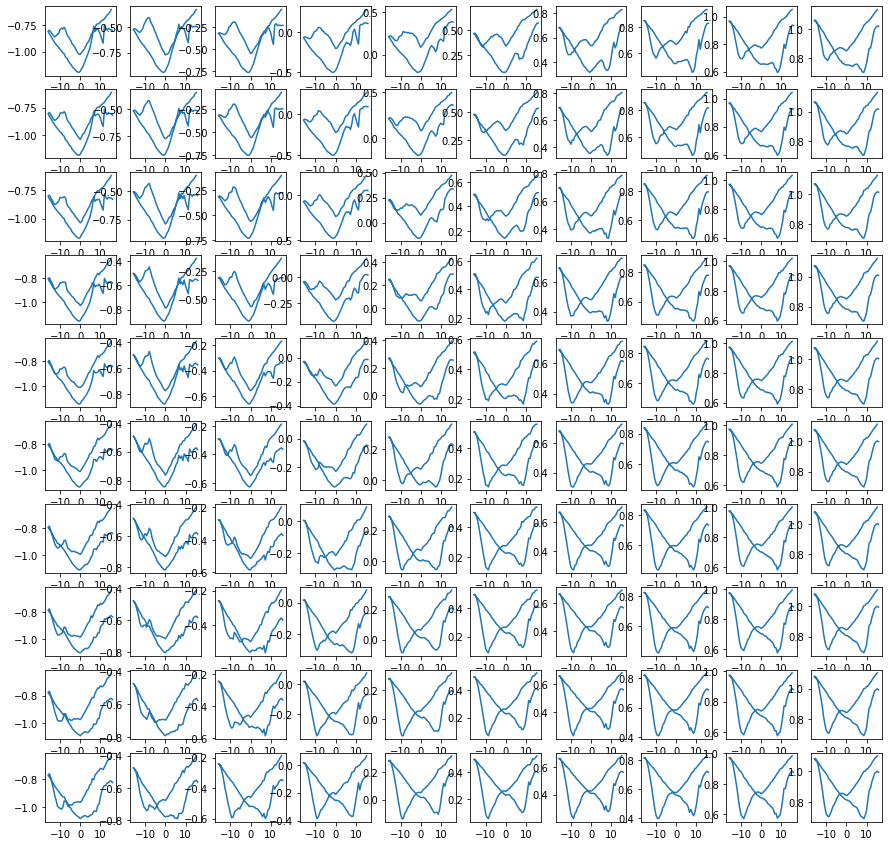

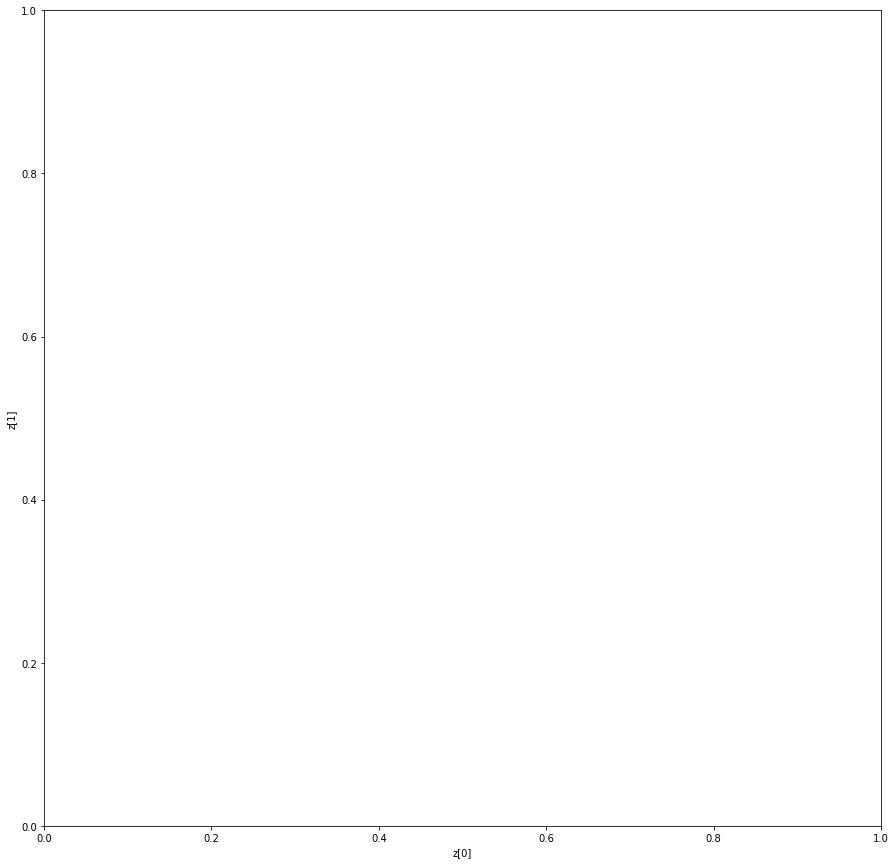

In [53]:
plot_latent(model_2.decoder_model)

In [58]:
model.decoder_model.layers[27]

In [21]:
earlyPredictor = Model(model.decoder_model.inputs,model.decoder_model.get_layer('embedding').output)

In [24]:
earlyPredictor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 16)]              0         
_________________________________________________________________
embedding (Dense)            (None, 16)                272       
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


In [25]:
embedding.shape

(3600, 16)

In [26]:
outer = earlyPredictor.predict(embedding)

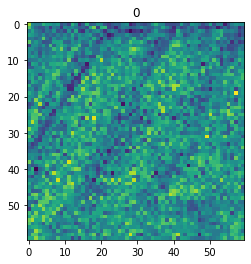

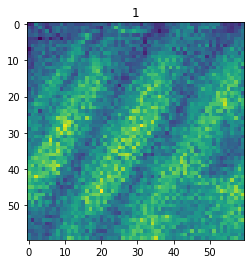

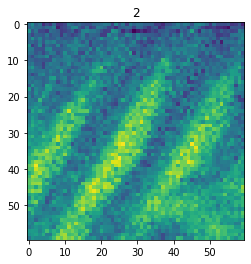

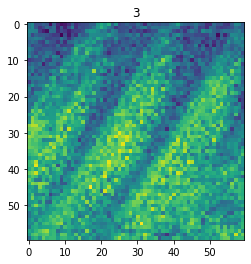

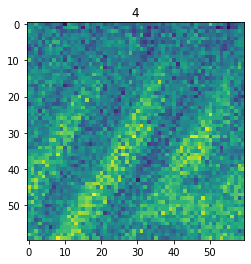

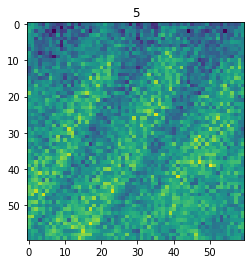

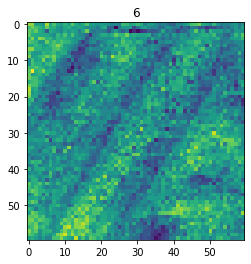

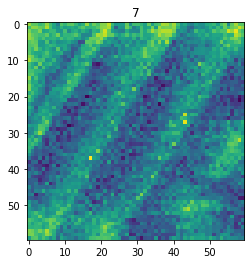

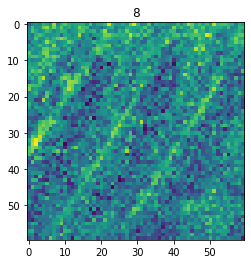

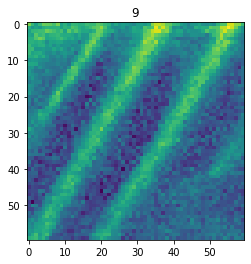

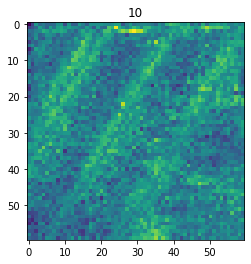

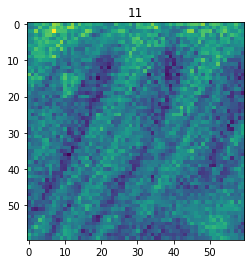

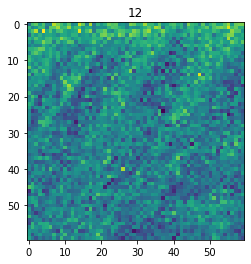

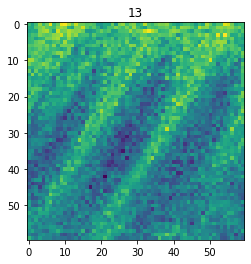

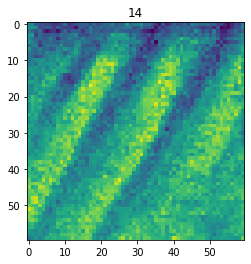

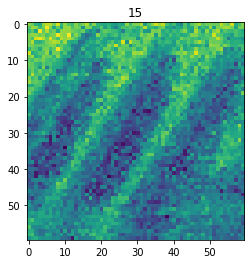

In [27]:
for i in range(16):
  plt.figure()
  plt.imshow(outer[:,i].reshape(60,60))
  plt.title(i)

In [ ]:
from tensorflow.keras import backend as k
two = k.function([model.sampling], model.vae.output)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: sampling/add:0


ValueError: ignored

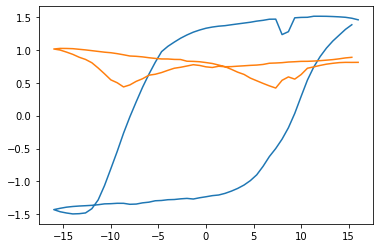

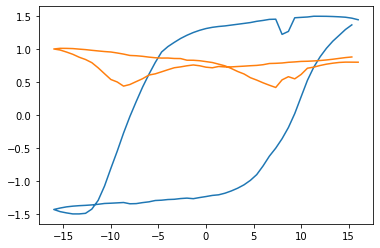

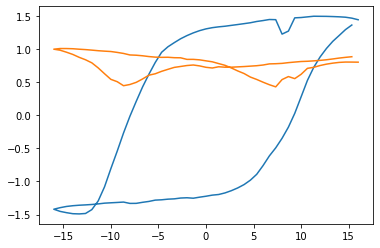

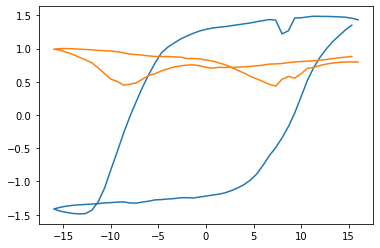

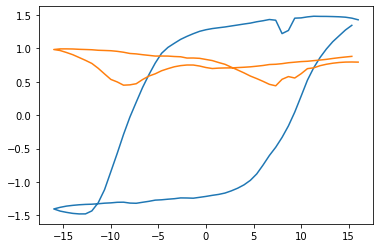

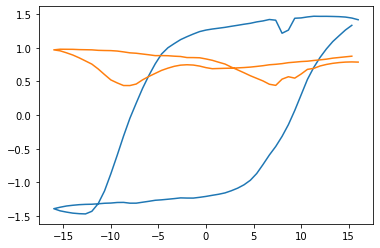

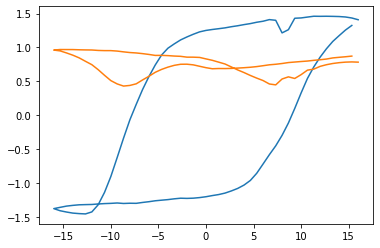

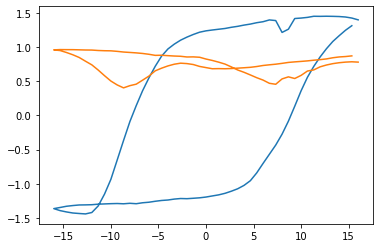

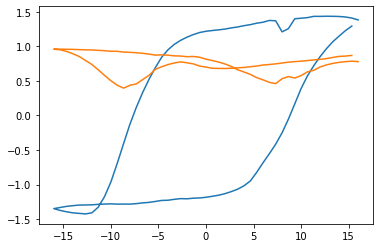

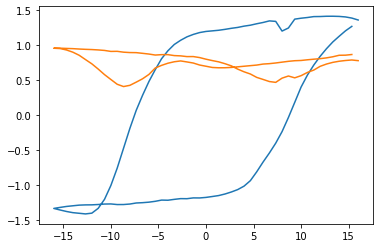

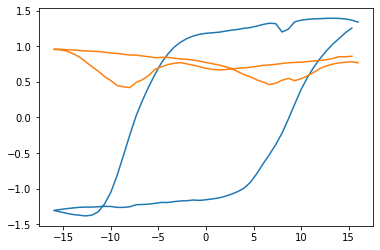

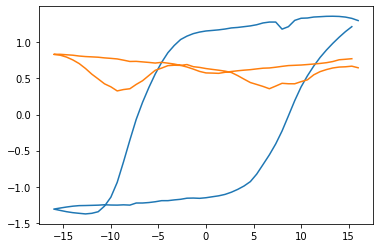

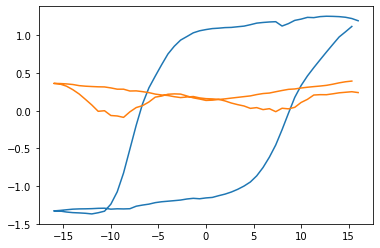

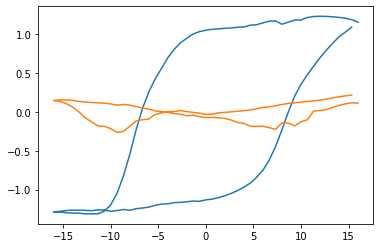

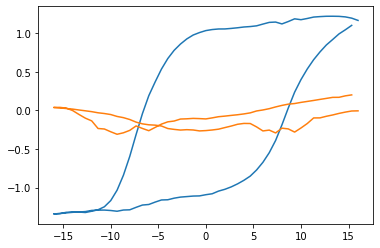

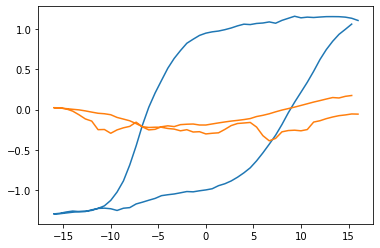

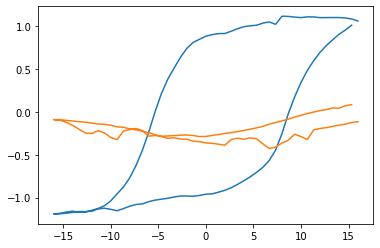

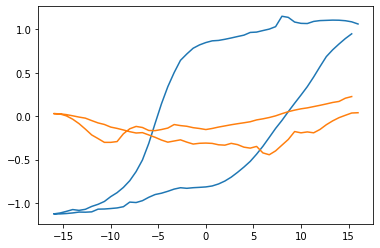

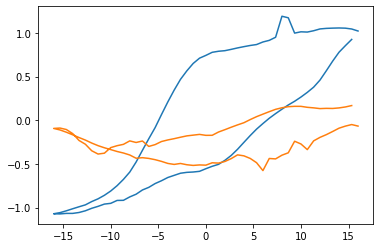

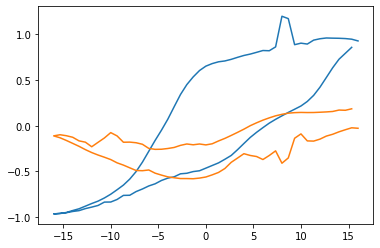

In [53]:
z = np.zeros((1,16))

for i in range(20):
  z = np.zeros((1,16))
  plt.figure()
# gaussian
#  z[:,7] = np.linspace(-3,3,30)[i]
  z[:,7] = np.g

  plt.plot(vol,model.decoder_model.predict(z).squeeze())

In [ ]:
embedding = get_ith_layer_output(model.vae, np.atleast_3d(scaled_data), 24)

ValueError: ignored

In [ ]:
model.decoder_model.layers

In [ ]:
np.save('/content/drive/My Drive/papers/Faster_Better_Paper/' + run_id + '/Data_file',scaled_data)

NameError: ignored

In [ ]:
# sets the file path
filepath = folder + '/triple_phase_weights2.{epoch:06d}-{loss:.4f}.hdf5'

# callback for saving checkpoints. Checkpoints are only saved when the model improves
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss',
                                              verbose=0, save_best_only=True,
                                              save_weights_only=True, mode='min')

In [ ]:
model.model.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/scaled_Layer_Norm_Triple_Phase_no_VAE_embedding_16_layer_size_128_l1_norm_0_l1_norm_0.001_VAE_False_coeff_0/triple_phase_weights.000997-0.0136.hdf5')

In [ ]:
model.model.fit(np.atleast_3d(scaled_data),
                np.atleast_3d(scaled_data),
                batch_size=320, epochs=1000, callbacks=[checkpoint])

In [ ]:
out = model.model.predict(np.atleast_3d(scaled_data), batch_size=320)

3086


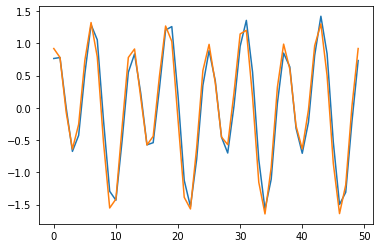

In [ ]:
i = np.random.randint(0,out.shape[0])
print(i)
plt.plot(out[i])
plt.plot(scaled_data[i])

In [ ]:
def get_activations(model, X=[], i=[], mode='test'):
    """
    function to get the activations of a specific layer
    this function can take either a model and compute the activations or can load previously
    generated activations saved as an numpy array
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    activation : float
        array containing the output from layer i of the network
    """
    # if a string is passed loads the activations from a file
    if isinstance(model, str):
        activation = np.load(model)
        print(f'activations {model} loaded from saved file')
    else:
        # computes the output of the ith layer
        activation = get_ith_layer_output(model, np.atleast_3d(X), i, model)

    return activation


def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output
